In [1]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from chronos import Chronos2Pipeline

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.ticker as ticker
import seaborn as sns
import os
import json

from SalesDataLoader import *

/Users/luisgrewe/Documents/StockSalesPrediction/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_loader = SalesDataLoader(train_path='data/df_stock_sales_train.xlsx', test_path='data/df_stock_sales_test.xlsx', 
                 date_col='week', target_col='sales', 
                 id_cols=['store_number', 'product_number'])
df = data_loader.load_raw_data()

df_train = df["train"]
df_test = df["test"]
target_blue = "#4293D0"

In [3]:
folders = ['images', 'results']

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f"Created folder: {folder}")
    else:
        print(f"Folder already exists: {folder}")

Folder already exists: images
Folder already exists: results


## Data Quality

In [4]:
date_distribution = df_train['week'].value_counts().sort_index()
print(f"Minimum Rows in one week: {date_distribution.min()}")
print(f"Maximum Rows in one week: {date_distribution.max()}")

Minimum Rows in one week: 599
Maximum Rows in one week: 599


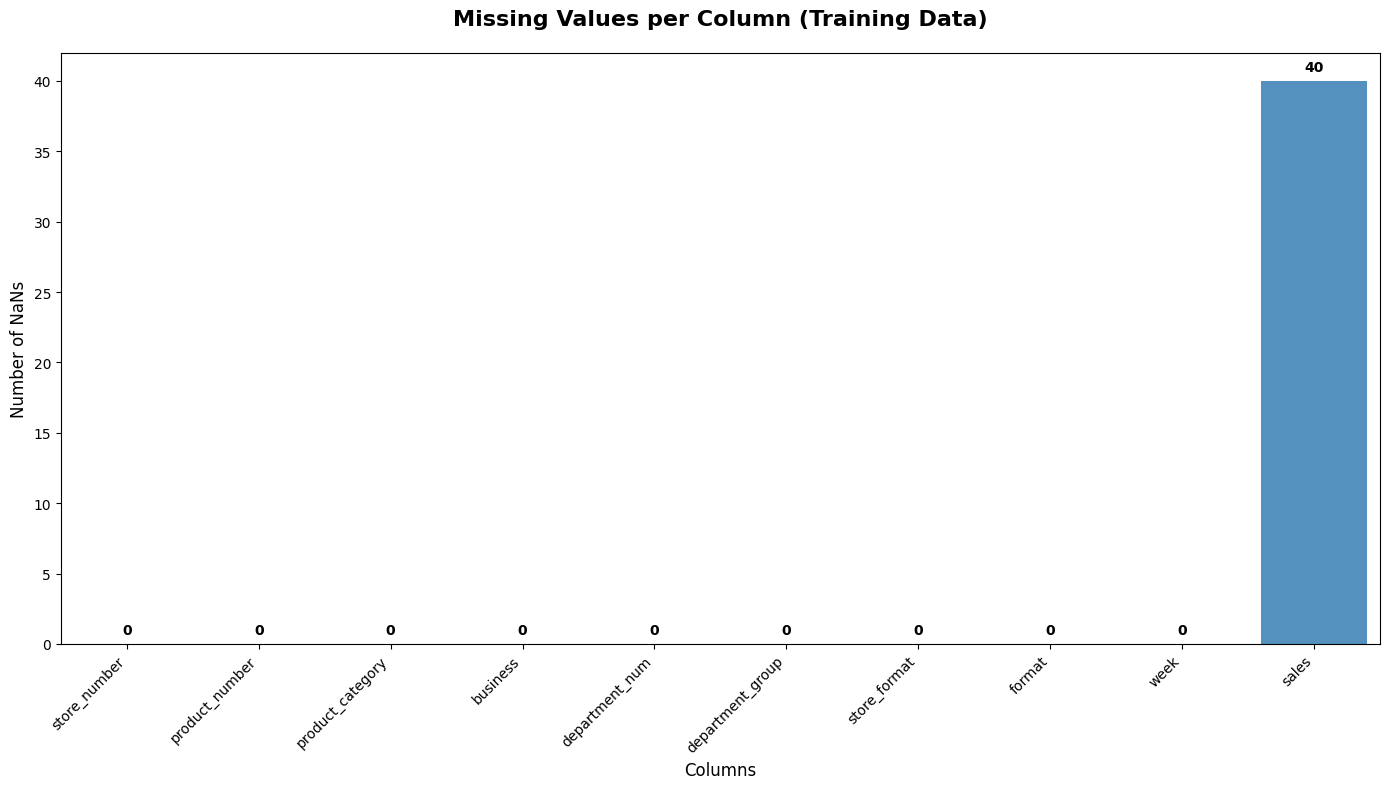

In [5]:
nan_counts = df_train.isna().sum()

plt.figure(figsize=(14, 8))
sns.barplot(x=nan_counts.index, y=nan_counts.values, color="#4293D0")

plt.title("Missing Values per Column (Training Data)", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Number of NaNs", fontsize=12)
plt.xlabel("Columns", fontsize=12)
plt.xticks(rotation=45, ha='right')

for i, val in enumerate(nan_counts.values):
    plt.text(i, val + 0.5, str(val), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('images/missing_values.png', dpi=300)
plt.show()

## Exploratory Data Analysis

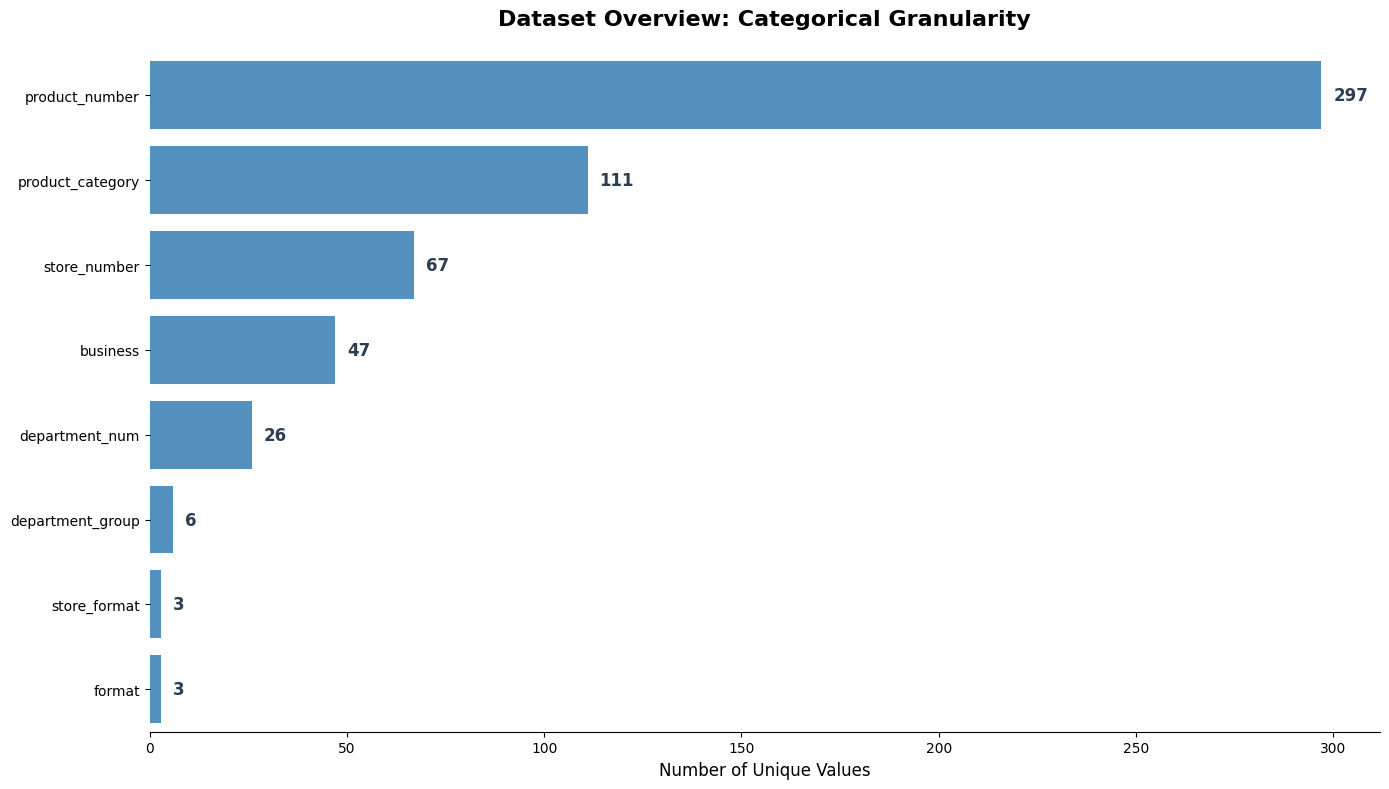

In [6]:
def display_dataset_summary_en(df):
    cols = [
        'product_number', 'product_category', 'business',
        'department_num', 'department_group', 'store_format', 'format', 'store_number'
    ]
    summary_data = [{'Dimension': col, 'Unique Count': df[col].nunique()} for col in cols]
    summary_df = pd.DataFrame(summary_data).sort_values('Unique Count', ascending=False)

    plt.figure(figsize=(14, 8))
    #sns.set_style("white") 
    
    target_blue = "#4293D0"

    ax = sns.barplot(
        x='Unique Count',
        y='Dimension',
        data=summary_df,
        color=target_blue
    )

    max_val = summary_df['Unique Count'].max()
    for p in ax.patches:
        width = p.get_width()
        plt.text(width + (max_val * 0.01), 
                 p.get_y() + p.get_height()/2,
                 f'{int(width):,}', 
                 va='center', fontsize=12, fontweight='bold', color='#2c3e50')

    plt.title('Dataset Overview: Categorical Granularity', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Unique Values', fontsize=12)
    plt.ylabel('')
    
    sns.despine(left=True, bottom=False)

    plt.tight_layout()
    plt.savefig('images/unique_values_presentation.png', dpi=300)
    plt.show()

display_dataset_summary_en(df_train)

## Correlation store_format and format

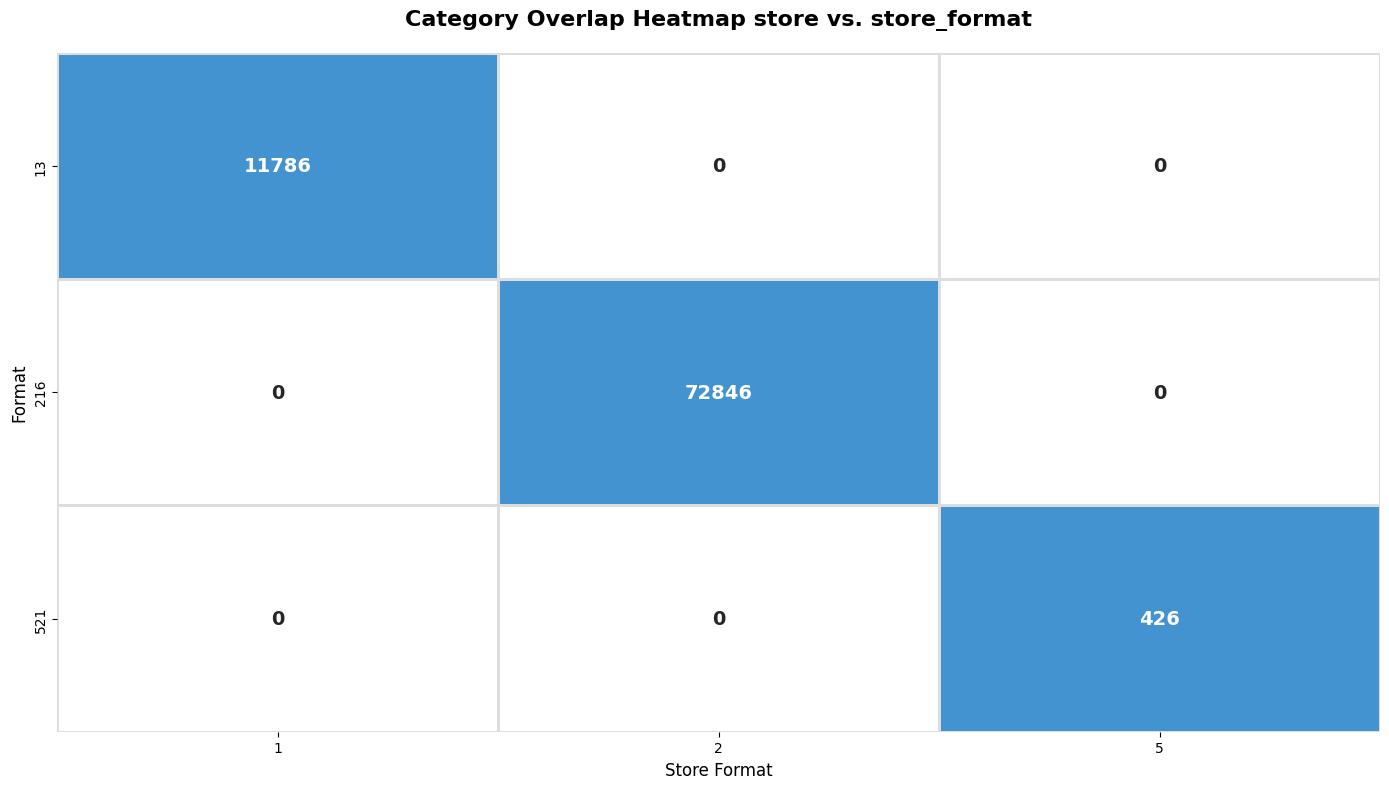

In [7]:
contingency_table = pd.crosstab(df_train['format'], df_train['store_format'])

target_blue = "#4293D0"
binary_cmap = ListedColormap(['#ffffff', target_blue])

plt.figure(figsize=(14, 8))

# Create the heatmap
sns.heatmap(contingency_table, 
            annot=True, 
            fmt='d', 
            cmap=binary_cmap, 
            vmin=0, 
            vmax=1, 
            cbar=False, 
            linewidths=1, 
            linecolor='#DDDDDD',
            # Set font size to 14 and keep it bold for visibility
            annot_kws={"size": 14, "weight": "bold"})

# Spearman correlation
correlation_value = df_train['store_format'].astype('category').cat.codes.corr(
    df_train['format'].astype('category').cat.codes, method='spearman')

plt.title(f'Category Overlap Heatmap store vs. store_format', 
          fontsize=16, 
          pad=20,
          fontweight='bold')

plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Format', fontsize=12)

plt.tight_layout()
plt.savefig("images/correlation_format_store-format.png", dpi=300)
plt.show()

In [8]:
X_train_preprocessed = data_loader.preprocessing(df_train)
X_test_preprocessed = data_loader.preprocessing(df_test)

X_train_preprocessed.dtypes

store_number                 int64
product_number               int64
product_category             int64
business                     int64
department_num               int64
department_group             int64
store_format                 int64
week                datetime64[ns]
sales                      float64
month                        int32
week_of_year                 int64
year                         int64
dtype: object

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_80669/2721058497.py:3: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)


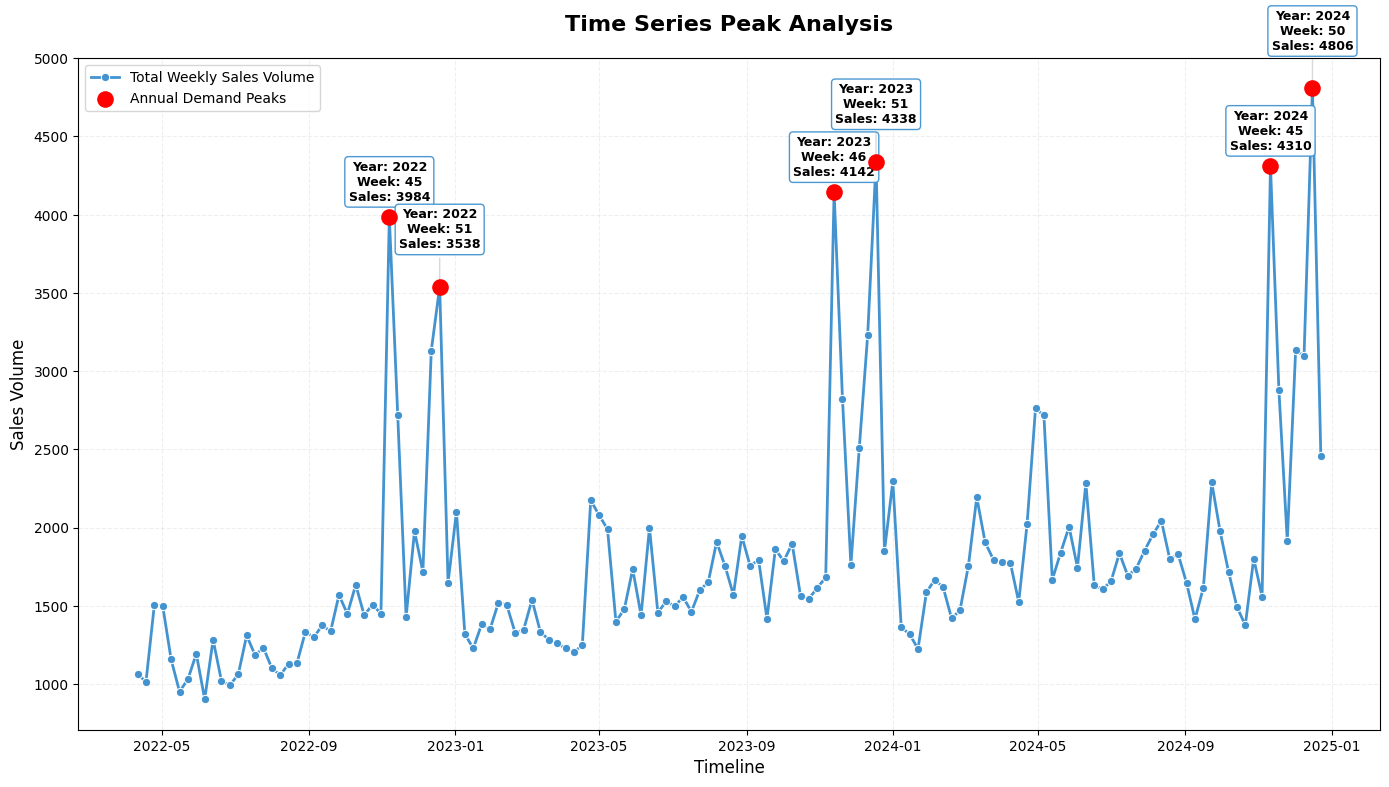

In [9]:
weekly_sales = X_train_preprocessed.groupby(['year', 'week'])['sales'].sum().reset_index()

peaks = weekly_sales.groupby('year').apply(lambda x: x.nlargest(2, 'sales')).reset_index(drop=True)
peaks = peaks.sort_values('week')

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=weekly_sales, 
    x='week', 
    y='sales', 
    marker='o', 
    color=target_blue, 
    linewidth=2, 
    label='Total Weekly Sales Volume'
)

plt.scatter(peaks['week'], peaks['sales'], color='red', s=120, zorder=5, label='Annual Demand Peaks')

for i, (_, row) in enumerate(peaks.iterrows()):
    week_num = row['week'].strftime('%U')
    
    # Smaller offsets to pull the boxes closer to the points
    y_offset = 12 if i % 2 == 0 else 28
    
    plt.annotate(
        f"Year: {int(row['year'])}\nWeek: {week_num}\nSales: {int(row['sales'])}",
        xy=(row['week'], row['sales']),
        xytext=(0, y_offset), 
        textcoords='offset points',
        ha='center',
        fontsize=9,
        fontweight='bold',
        # Subtle arrow to maintain the link without clutter
        arrowprops=dict(arrowstyle='-', color='gray', alpha=0.3),
        # Professional thin-border box in your target blue
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=target_blue, lw=1, alpha=0.95)
    )

plt.title('Time Series Peak Analysis', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Timeline', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.2)
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('images/final_time_series_2peaks.png', dpi=300)
plt.show()

## Store Variety

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_80669/894235783.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


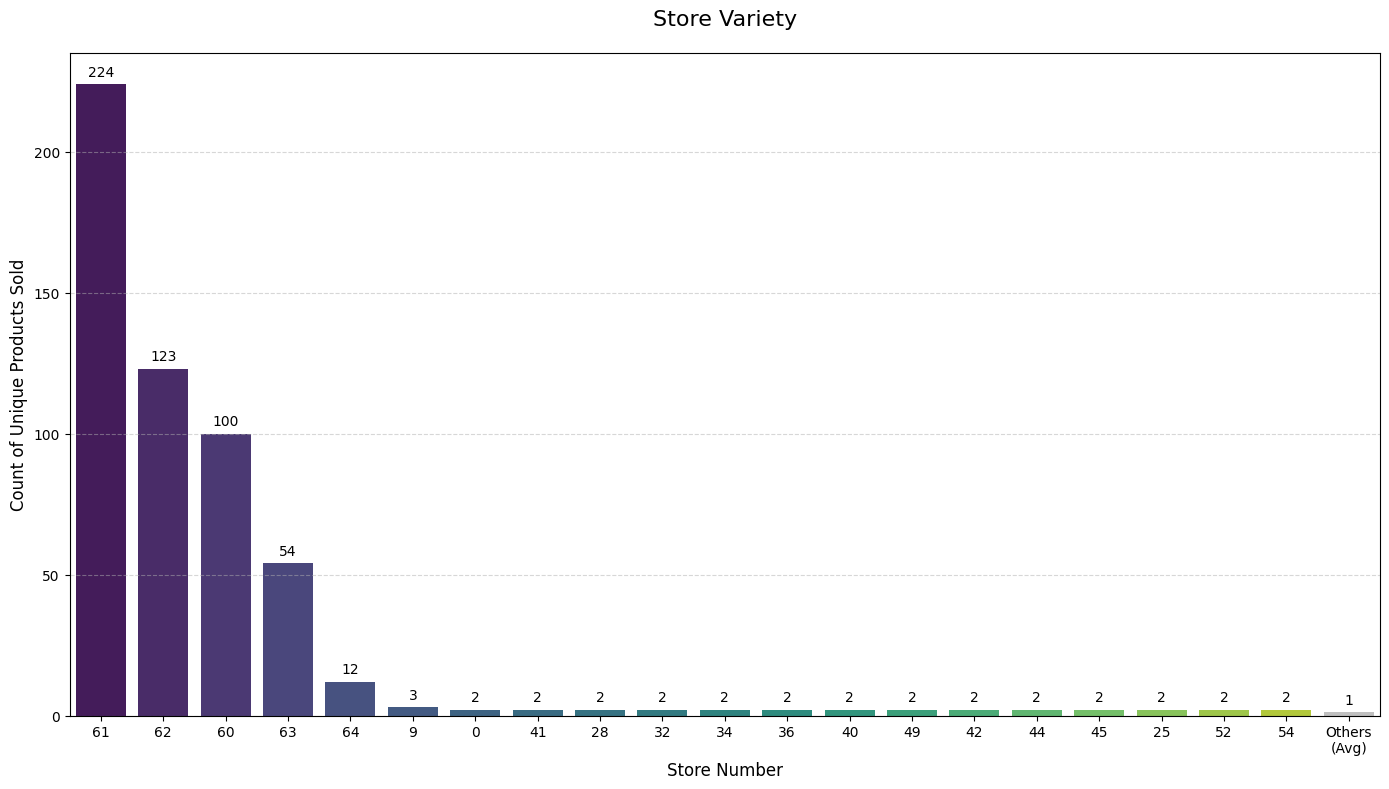

In [10]:
store_total_variety = X_train_preprocessed[X_train_preprocessed['sales'] > 0].groupby('store_number')['product_number'].nunique().sort_values(ascending=False).reset_index()
store_total_variety.columns = ['store_number', 'total_unique_products']

top_n = 20

if len(store_total_variety) > top_n:
    # Extract Top N stores
    top_stores = store_total_variety.head(top_n).copy()

    others_val = store_total_variety.iloc[top_n:]['total_unique_products'].mean()

    # Combine smaller stores
    others_df = pd.DataFrame({
        'store_number': ['Others\n(Avg)'],
        'total_unique_products': [others_val]
    })

    plot_data = pd.concat([top_stores, others_df], ignore_index=True)
else:
    plot_data = store_total_variety

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='store_number',
    y='total_unique_products',
    palette='viridis'
)

if len(store_total_variety) > top_n:
    plt.gca().patches[-1].set_facecolor('gray')
    plt.gca().patches[-1].set_alpha(0.5)

plt.title(f'Store Variety', fontsize=16, pad=20)
plt.xlabel('Store Number', fontsize=12)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
#plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add value labels
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}',
                       (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha = 'center', va = 'center',
                       xytext = (0, 9),
                       textcoords = 'offset points',
                       fontsize=10)

plt.tight_layout()
plt.savefig('images/store_variety.png')
plt.show()

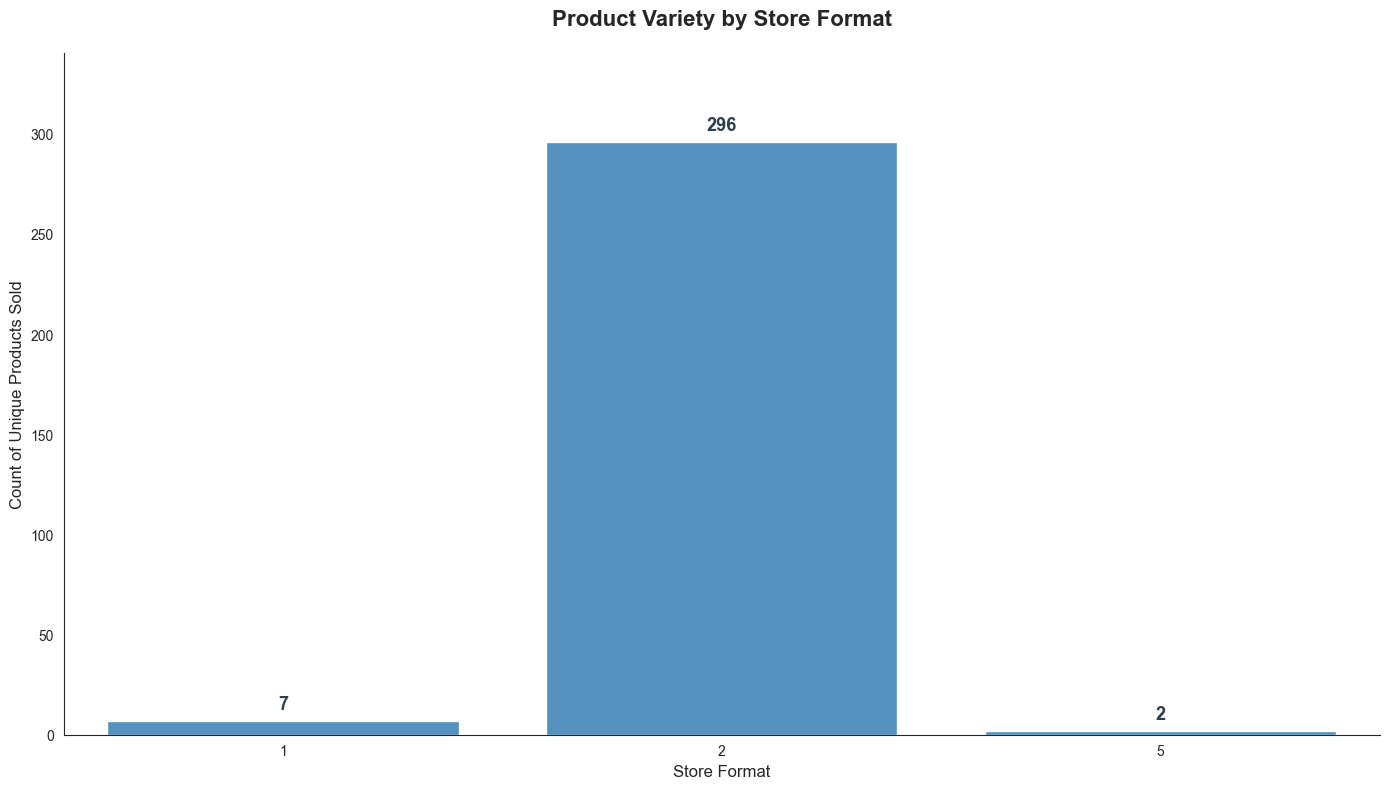

In [11]:
format_variety = (
    X_train_preprocessed[X_train_preprocessed['sales'] > 0]
    .groupby('store_format')['product_number']
    .nunique()
    .sort_values(ascending=False)
    .reset_index()
)
format_variety.columns = ['store_format', 'unique_products']

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=format_variety,
    x='store_format',
    y='unique_products',
    color=target_blue
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height):,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center',
                xytext=(0, 12),
                textcoords='offset points',
                fontsize=13, fontweight='bold', color='#2c3e50')

plt.title('Product Variety by Store Format', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Count of Unique Products Sold', fontsize=12)
plt.xlabel('Store Format', fontsize=12)

plt.ylim(0, format_variety['unique_products'].max() * 1.15)

sns.despine()

plt.tight_layout()
plt.savefig('images/store_format_variety.png', dpi=300)
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_80669/1928865507.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')


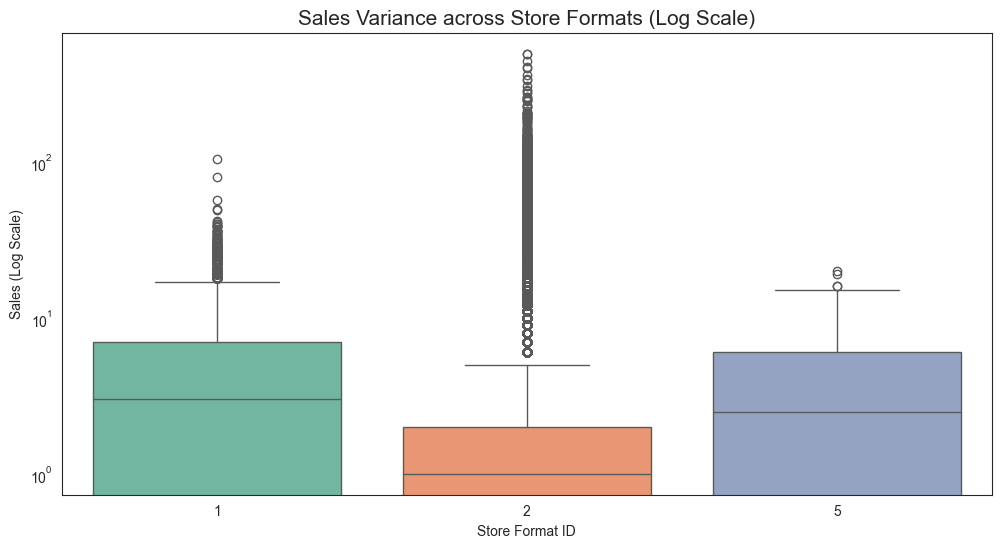

In [12]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=X_train_preprocessed, x='store_format', y='sales', palette='Set2')
plt.yscale('log')
plt.title('Sales Variance across Store Formats (Log Scale)', fontsize=15)
plt.xlabel('Store Format ID')
plt.ylabel('Sales (Log Scale)')
plt.savefig('images/boxplot_store_format_variance.png')
plt.show()

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_80669/544766282.py:28: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


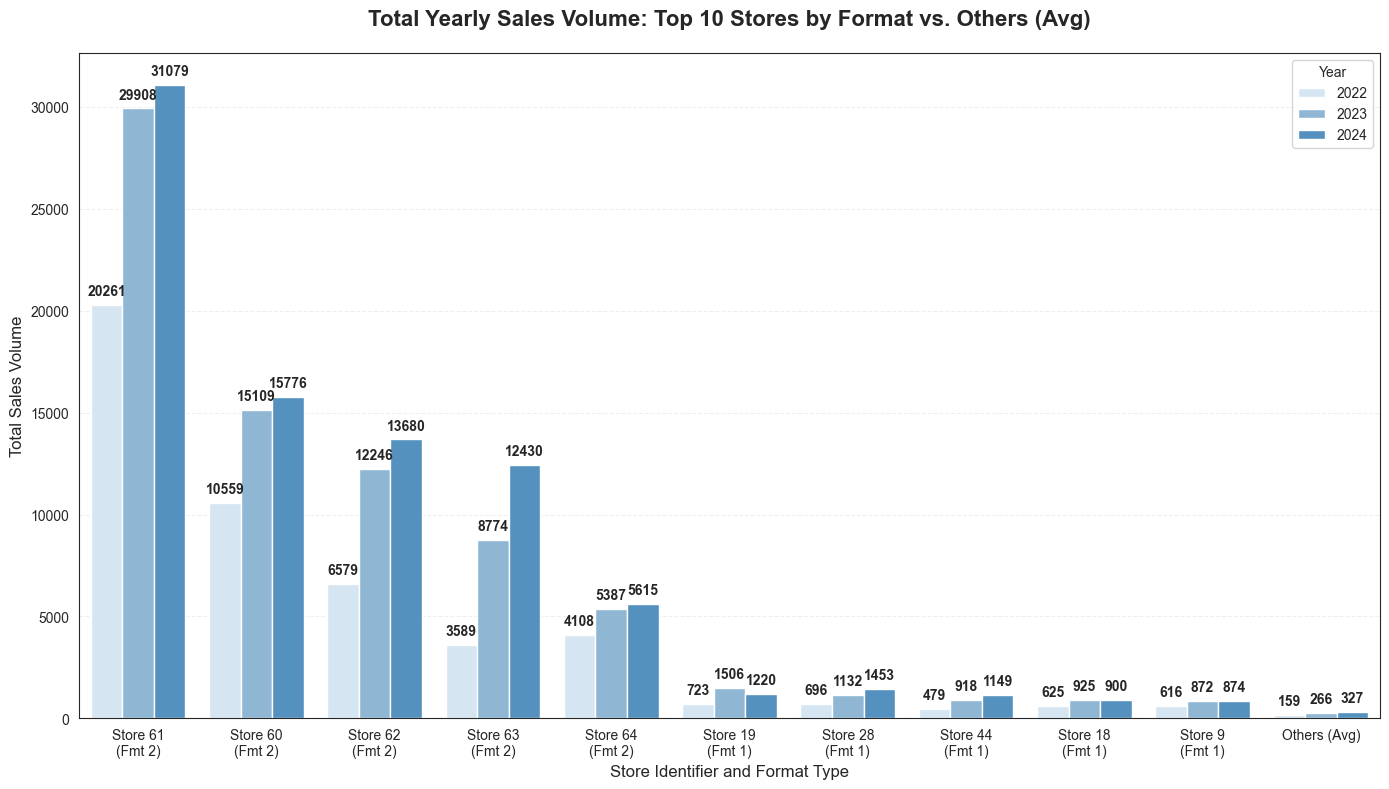

In [13]:
store_format_mapping = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()
store_yearly_sales = X_train_preprocessed.groupby(['store_number', 'year'])['sales'].sum().reset_index()

top_n = 10
top_stores_list = store_yearly_sales.groupby('store_number')['sales'].sum().nlargest(top_n).index

top_stores_df = store_yearly_sales[store_yearly_sales['store_number'].isin(top_stores_list)].copy()
top_stores_df = top_stores_df.merge(store_format_mapping, on='store_number', how='left')

top_stores_df['display_label'] = "Store " + top_stores_df['store_number'].astype(str) + \
                                 "\n(Fmt " + top_stores_df['store_format'].astype(str) + ")"

others_df = store_yearly_sales[~store_yearly_sales['store_number'].isin(top_stores_list)].copy()
others_yearly = others_df.groupby('year')['sales'].mean().reset_index()
others_yearly['display_label'] = 'Others (Avg)'

plot_data = pd.concat([top_stores_df, others_yearly], ignore_index=True)

order = top_stores_df.groupby('display_label')['sales'].sum().sort_values(ascending=False).index.tolist()
order.append('Others (Avg)')

target_blue = "#4293D0"
num_years = plot_data['year'].nunique()
colors_list = ["#D0E6F7", "#84B9E0", target_blue]
custom_palette = LinearSegmentedColormap.from_list("custom_blues", colors_list)(np.linspace(0, 1, num_years))

plt.figure(figsize=(14, 8))
sns.barplot(
    data=plot_data,
    x='display_label',
    y='sales',
    hue='year',
    palette=custom_palette, 
    order=order
)

plt.title(f'Total Yearly Sales Volume: Top {top_n} Stores by Format vs. Others (Avg)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Identifier and Format Type', fontsize=12)
plt.ylabel('Total Sales Volume', fontsize=12)
plt.legend(title='Year', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.3)

for p in plt.gca().patches:
    height = p.get_height()
    if height > 0:
        plt.gca().annotate(f'{int(height)}',
                           (p.get_x() + p.get_width() / 2., height),
                           ha='center', va='center',
                           xytext=(0, 10),
                           textcoords='offset points',
                           fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('images/yearly_sales_volume_stores.png')
plt.show()

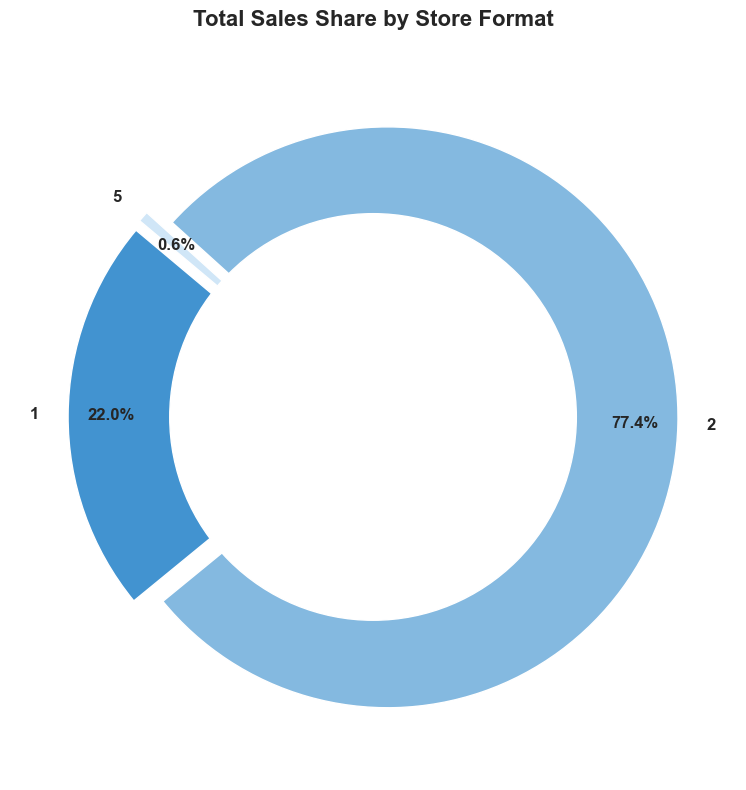

In [14]:
format_shares = X_train_preprocessed.groupby('store_format')['sales'].sum().reset_index()

plt.figure(figsize=(14, 8))
target_blue = "#4293D0"

colors = [target_blue, "#84B9E0", "#D0E6F7"] 

# Pie Chart
plt.pie(
    format_shares['sales'], 
    labels=format_shares['store_format'], 
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    pctdistance=0.85,
    explode=[0.05] * len(format_shares),
    textprops={'fontsize': 12, 'fontweight': 'bold'}
)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Total Sales Share by Store Format', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('images/sales_share_pie.png', dpi=300)
plt.show()

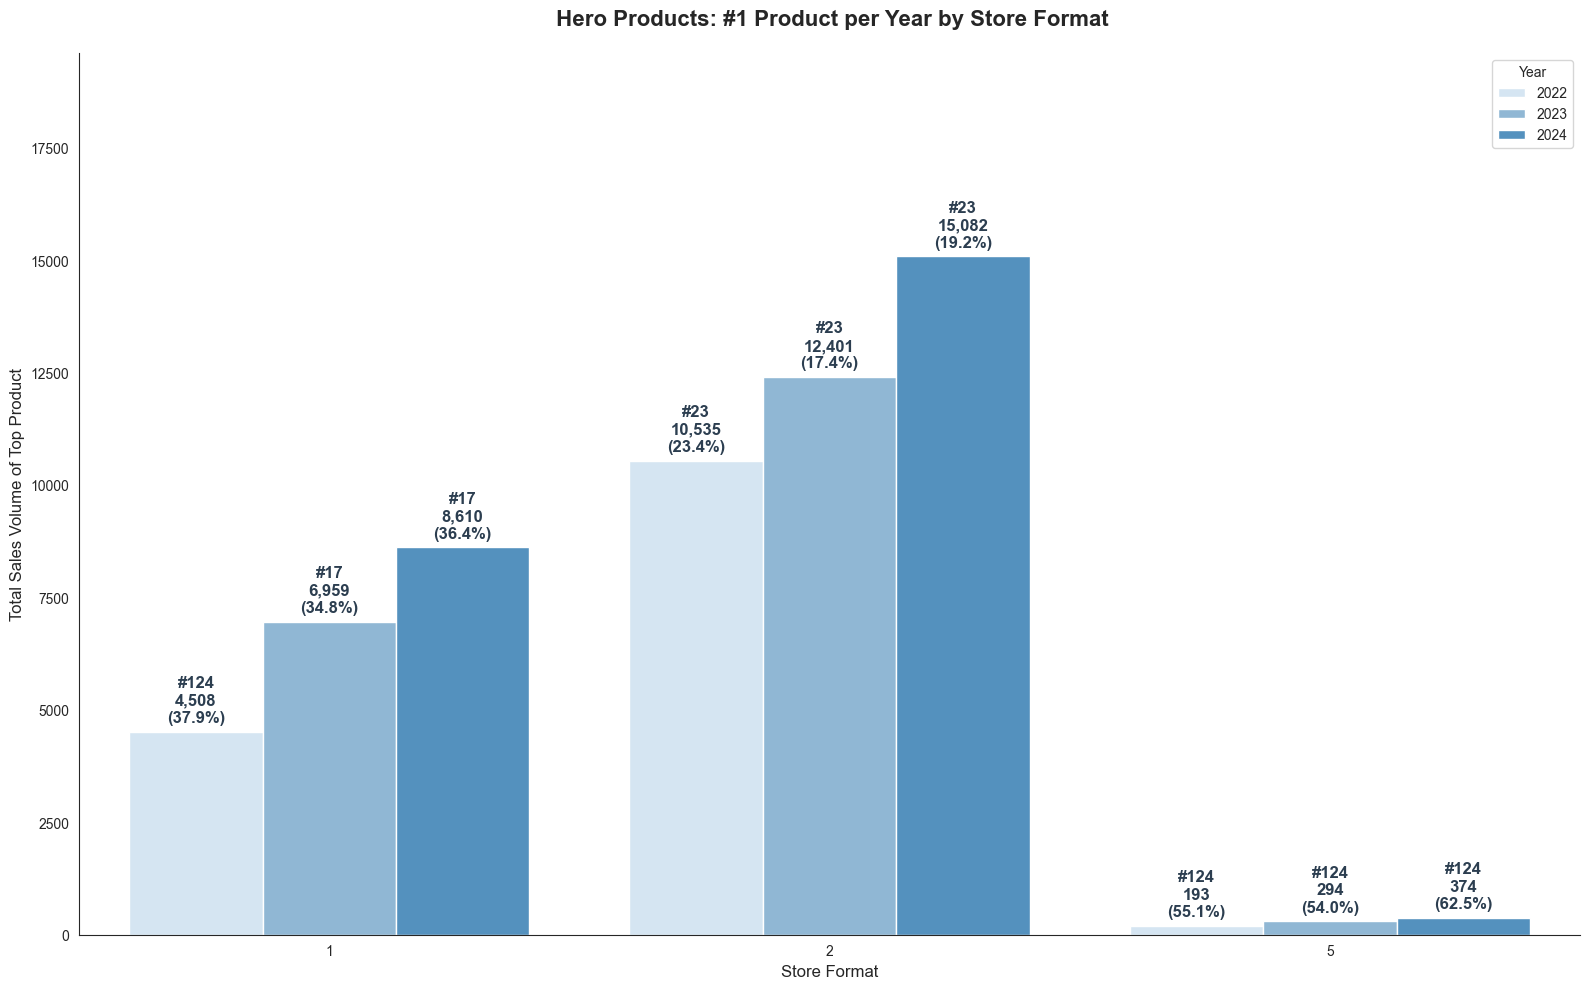

In [15]:
# Calculate Total Sales per Format per Year (The Denominator)
format_yearly_totals = (
    X_train_preprocessed.groupby(['store_format', 'year'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'sales': 'total_format_sales'})
)

# Get the #1 product for each format and year
yearly_heroes = (
    X_train_preprocessed.groupby(['store_format', 'year', 'product_number'])['sales']
    .sum()
    .reset_index()
    .sort_values(['store_format', 'year', 'sales'], ascending=[True, True, False])
)
top_1_per_year = yearly_heroes.groupby(['store_format', 'year']).head(1)

# Merge and Calculate Share Percentage
top_1_per_year = top_1_per_year.merge(format_yearly_totals, on=['store_format', 'year'])
top_1_per_year['share_pct'] = (top_1_per_year['sales'] / top_1_per_year['total_format_sales']) * 100

# Plotting
plt.figure(figsize=(16, 10))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=top_1_per_year, 
    x='store_format', 
    y='sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    errorbar=None
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        num_formats = len(top_1_per_year['store_format'].unique())
        year_idx = i // num_formats
        fmt_idx = i % num_formats
        
        years_list = sorted(top_1_per_year['year'].unique())
        formats_list = top_1_per_year['store_format'].unique()
        
        current_year = years_list[year_idx]
        current_fmt = formats_list[fmt_idx]
        
        row = top_1_per_year[
            (top_1_per_year['store_format'] == current_fmt) & 
            (top_1_per_year['year'] == current_year)
        ]
        
        if not row.empty:
            prod_num = row['product_number'].values[0]
            share = row['share_pct'].values[0]
            
            plt.text(p.get_x() + p.get_width() / 2., 
                     height + (top_1_per_year['sales'].max() * 0.01),
                     f'#{int(prod_num)}\n{int(height):,}\n({share:.1f}%)', 
                     ha='center', va='bottom', 
                     fontsize=12, fontweight='bold', color='#2c3e50')

plt.title(' Hero Products: #1 Product per Year by Store Format', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Total Sales Volume of Top Product', fontsize=12)
plt.legend(title='Year', loc='upper right', frameon=True)

plt.ylim(0, top_1_per_year['sales'].max() * 1.3)
sns.despine()
plt.tight_layout()
plt.savefig('images/dynamic_yearly_heroes.png', dpi=300)
plt.show()

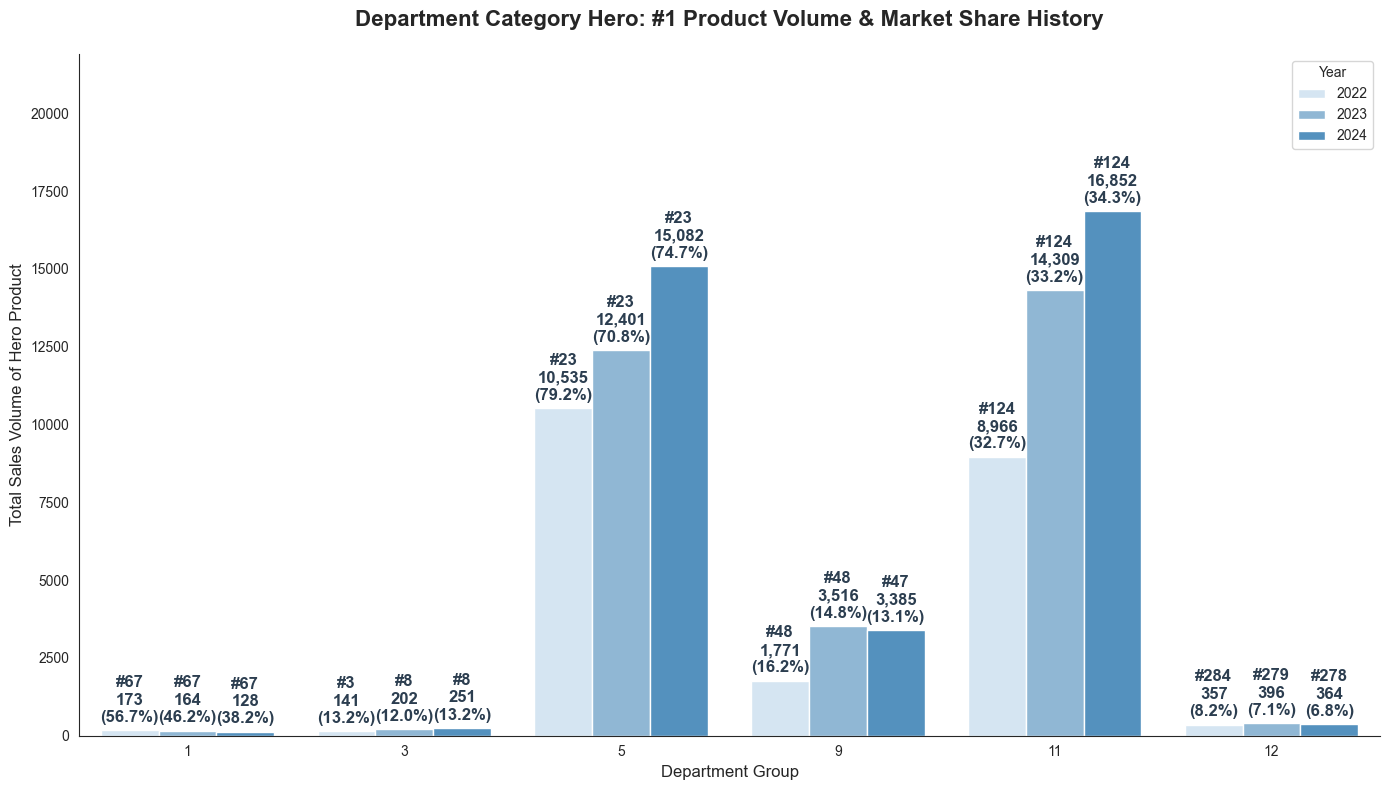

In [16]:
dept_yearly_totals = (
    X_train_preprocessed.groupby(['department_group', 'year'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'sales': 'total_dept_sales'})
)

yearly_dept_heroes = (
    X_train_preprocessed.groupby(['department_group', 'year', 'product_number'])['sales']
    .sum()
    .reset_index()
    .sort_values(['department_group', 'year', 'sales'], ascending=[True, True, False])
)

top_1_dept_year = yearly_dept_heroes.groupby(['department_group', 'year']).head(1)

top_1_dept_year = top_1_dept_year.merge(dept_yearly_totals, on=['department_group', 'year'])
top_1_dept_year['share_pct'] = (top_1_dept_year['sales'] / top_1_dept_year['total_dept_sales']) * 100

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=top_1_dept_year, 
    x='department_group', 
    y='sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    errorbar=None
)

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        # Determine current group based on patch order
        num_depts = len(top_1_dept_year['department_group'].unique())
        year_idx = i // num_depts
        dept_idx = i % num_depts
        
        years_list = sorted(top_1_dept_year['year'].unique())
        depts_list = top_1_dept_year['department_group'].unique()
        
        current_year = years_list[year_idx]
        current_dept = depts_list[dept_idx]
        
        row = top_1_dept_year[
            (top_1_dept_year['department_group'] == current_dept) & 
            (top_1_dept_year['year'] == current_year)
        ]
        
        if not row.empty:
            prod_num = row['product_number'].values[0]
            share = row['share_pct'].values[0]
            
            plt.text(p.get_x() + p.get_width() / 2., 
                     height + (top_1_dept_year['sales'].max() * 0.01),
                     f'#{int(prod_num)}\n{int(height):,}\n({share:.1f}%)', 
                     ha='center', va='bottom', 
                     fontsize=12, fontweight='bold', color='#2c3e50')

# Formatting for a clean slide look
plt.title('Department Category Hero: #1 Product Volume & Market Share History', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Department Group', fontsize=12)
plt.ylabel('Total Sales Volume of Hero Product', fontsize=12)
plt.legend(title='Year', loc='upper right', frameon=True)

plt.ylim(0, top_1_dept_year['sales'].max() * 1.3)
sns.despine()
plt.tight_layout()

plt.savefig('images/department_yearly_heroes.png', dpi=300)
plt.show()

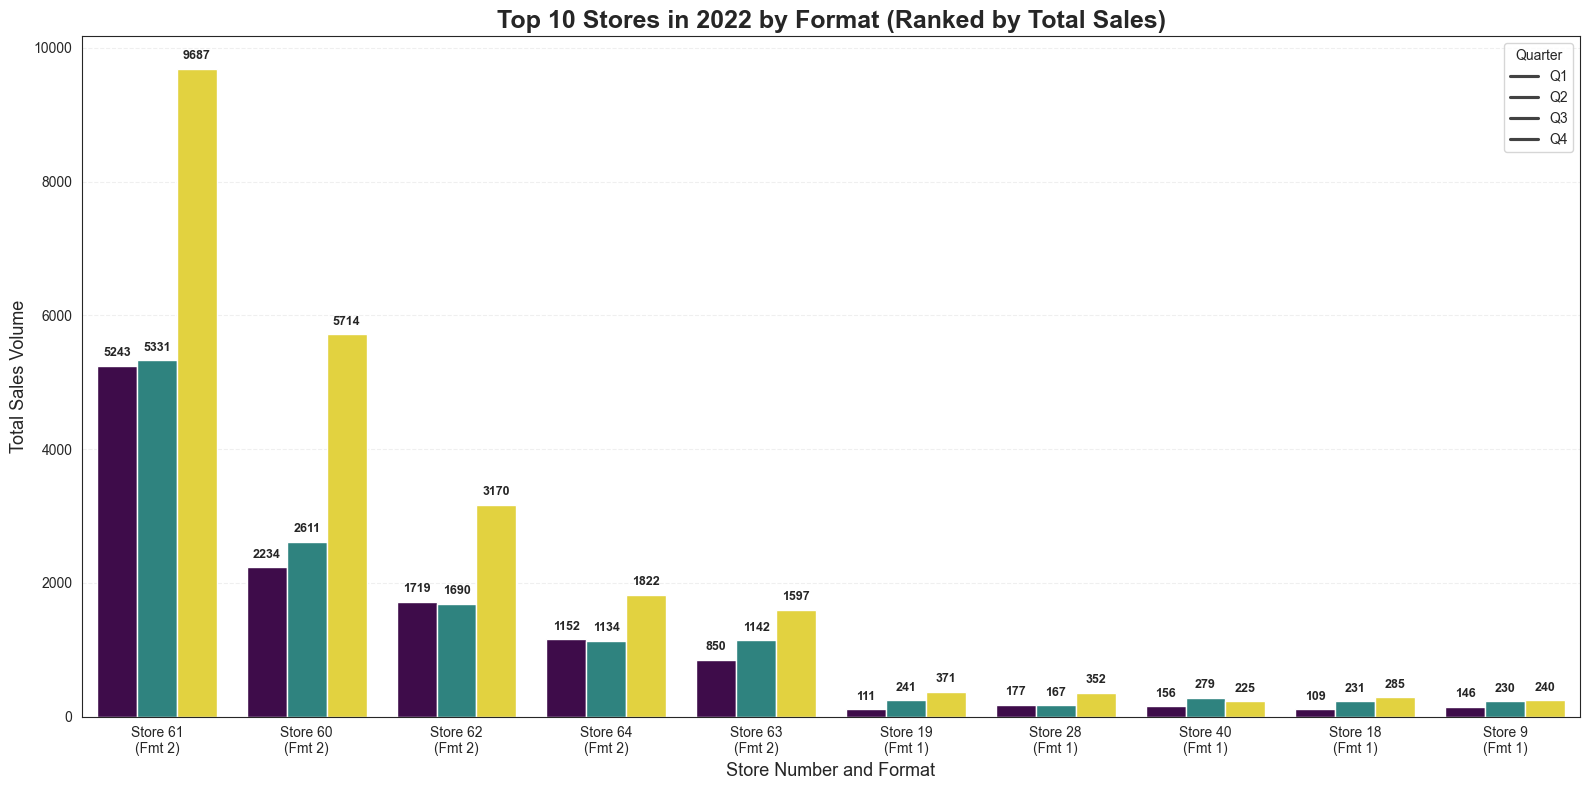

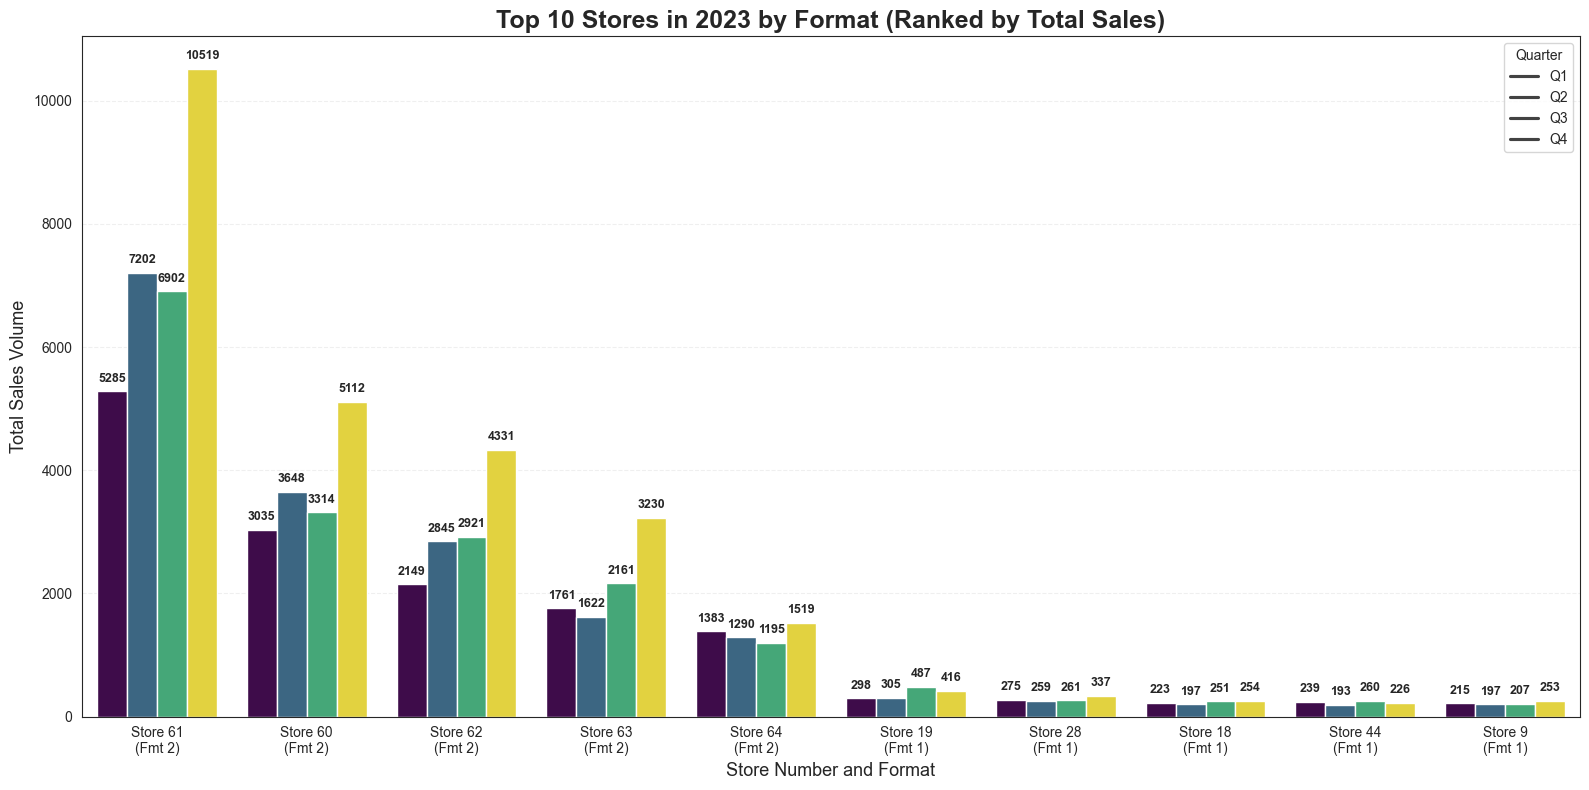

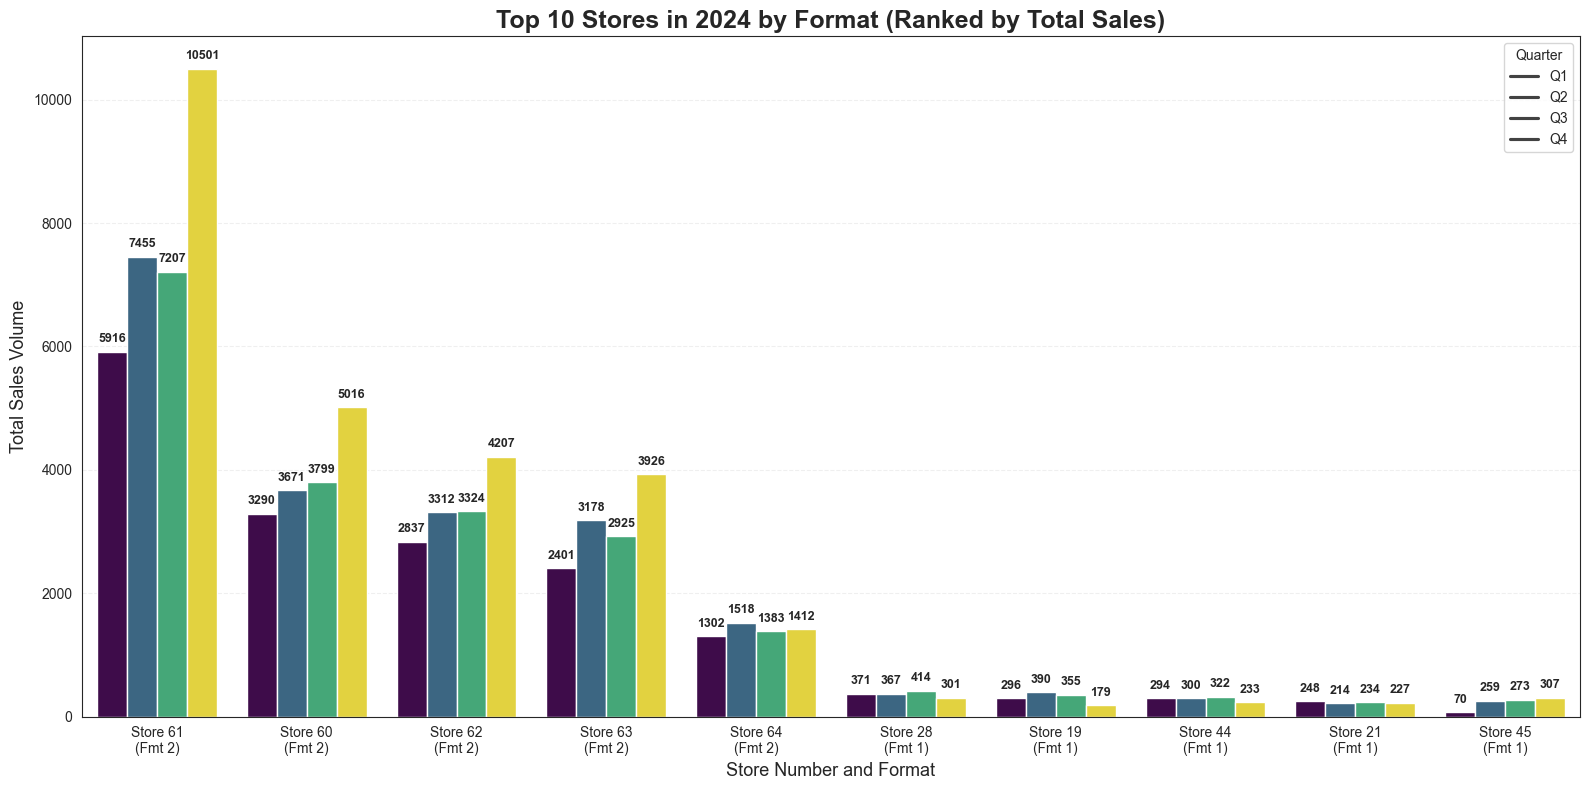

In [17]:
if 'quarter' not in X_train_preprocessed.columns:
    X_train_preprocessed['quarter'] = X_train_preprocessed['week'].dt.quarter

store_fmt_map = X_train_preprocessed[['store_number', 'store_format']].drop_duplicates()

yearly_store_stats = X_train_preprocessed.groupby(['year', 'store_number', 'quarter'])['sales'].sum().reset_index()

years = sorted(yearly_store_stats['year'].unique())

for year in years:
    year_data = yearly_store_stats[yearly_store_stats['year'] == year].copy()

    current_year_order = year_data.groupby('store_number')['sales'].sum().nlargest(10).index.tolist()

    plot_data = year_data[year_data['store_number'].isin(current_year_order)].copy()
    plot_data = plot_data.merge(store_fmt_map, on='store_number', how='left')

    plot_data['display_label'] = "Store " + plot_data['store_number'].astype(str) + \
                                 "\n(Fmt " + plot_data['store_format'].astype(str) + ")"

    # Re-calculate the order based on the new labels to keep the ranking
    label_order = [f"Store {s}\n(Fmt {store_fmt_map[store_fmt_map['store_number']==s]['store_format'].values[0]})"
                   for s in current_year_order]

    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=plot_data,
        x="display_label",
        y="sales",
        hue="quarter",
        palette="viridis",
        order=label_order
    )

    # Styling
    plt.title(f'Top 10 Stores in {year} by Format (Ranked by Total Sales)', fontsize=18, fontweight='bold')
    plt.xlabel('Store Number and Format', fontsize=13)
    plt.ylabel('Total Sales Volume', fontsize=13)
    plt.legend(title="Quarter", labels=['Q1', 'Q2', 'Q3', 'Q4'], loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Value Labels
    for p in plt.gca().patches:
        height = p.get_height()
        if height > 0:
            plt.gca().annotate(f'{int(height)}',
                               (p.get_x() + p.get_width() / 2., height),
                               ha='center', va='center',
                               xytext=(0, 9),
                               textcoords='offset points',
                               fontsize=9,
                               fontweight='bold')

    plt.tight_layout()
    save_path = f'images/top_stores_{year}.png'
    plt.savefig(save_path)
    plt.show()

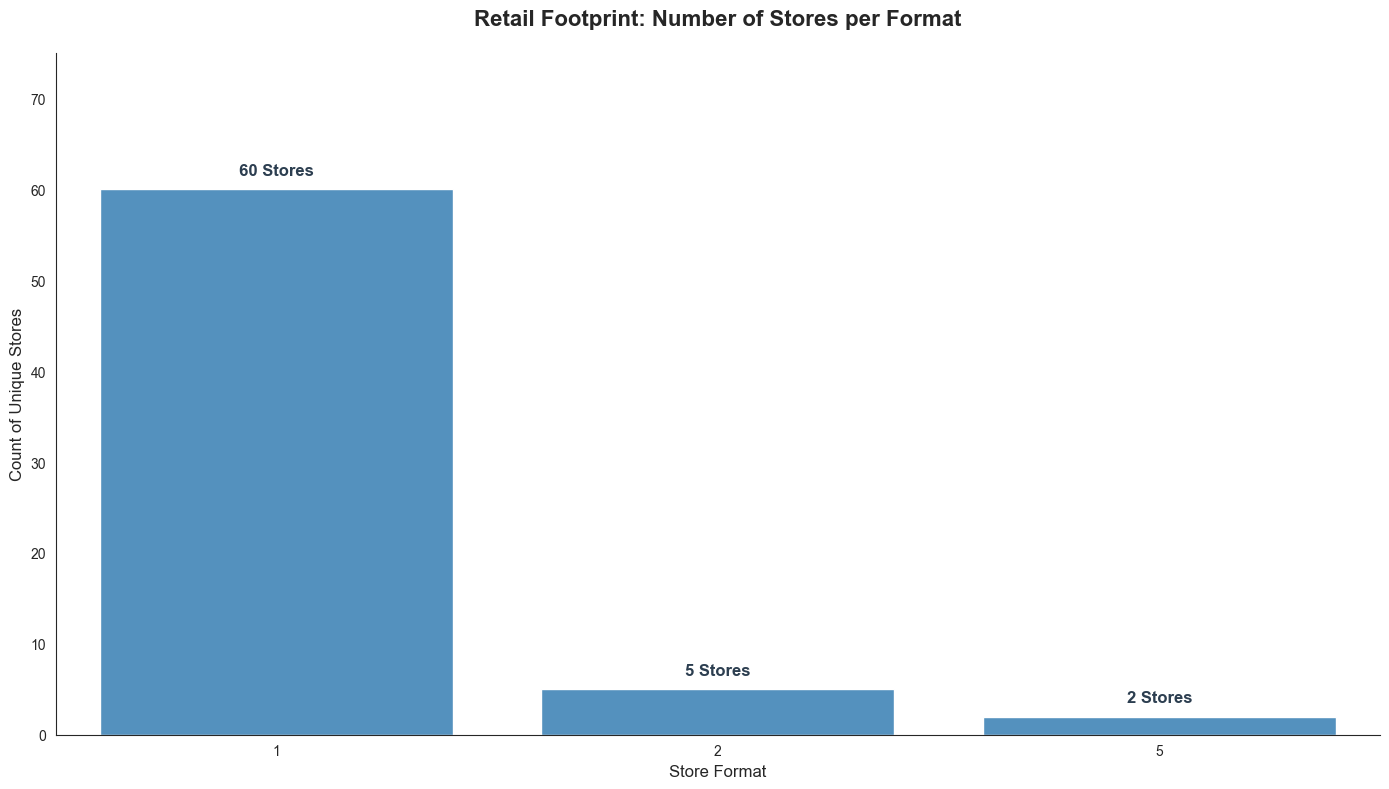

In [18]:
store_counts = df_train.groupby('store_format')['store_number'].nunique().reset_index()
store_counts.columns = ['store_format', 'store_count']
store_counts = store_counts.sort_values('store_count', ascending=False)

plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0"

ax = sns.barplot(
    data=store_counts,
    x='store_format',
    y='store_count',
    color=target_blue
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)} Stores',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize=12, fontweight='bold', color='#2c3e50')

plt.title('Retail Footprint: Number of Stores per Format', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Count of Unique Stores', fontsize=12)

# Add extra space at the top for labels
plt.ylim(0, store_counts['store_count'].max() * 1.25)

sns.despine()
plt.tight_layout()

# Save for your slide deck
plt.savefig('images/stores_per_format.png', dpi=300)
plt.show()

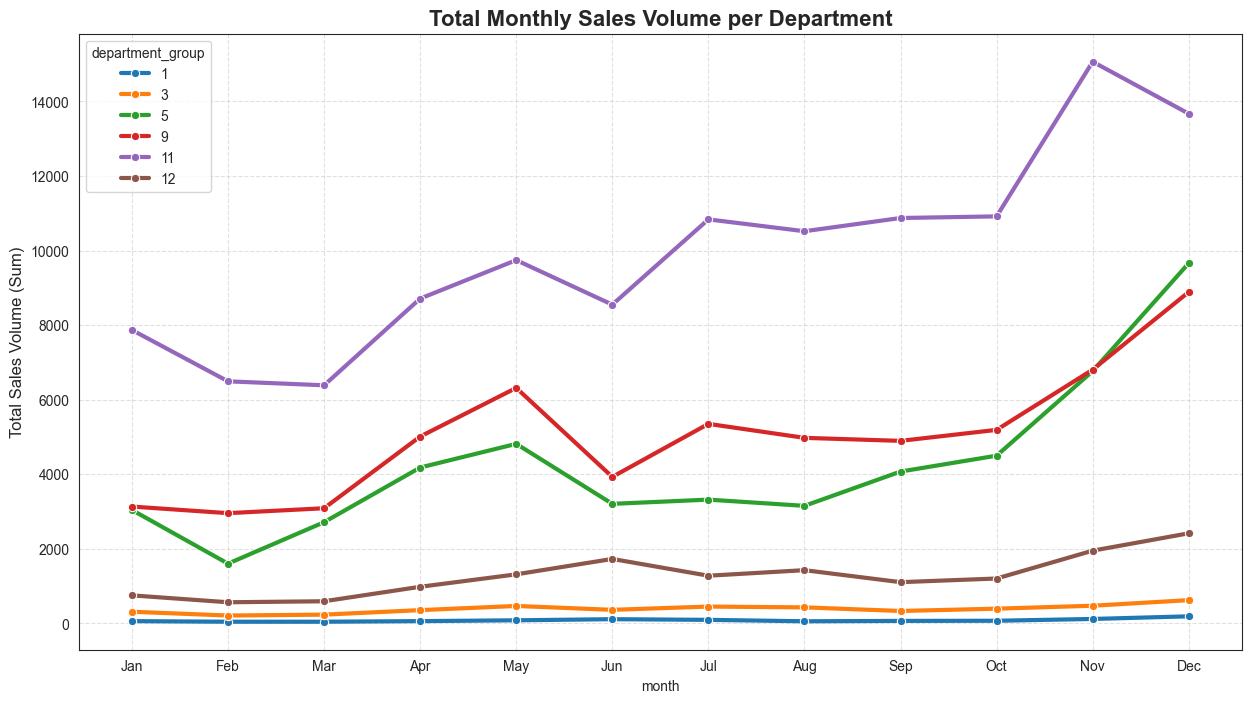

In [19]:
seasonal_sum = X_train_preprocessed.groupby(['department_group', 'month'])['sales'].sum().reset_index()

top_depts = X_train_preprocessed.groupby('department_group')['sales'].sum().index
plot_data = seasonal_sum[seasonal_sum['department_group'].isin(top_depts)]

plt.figure(figsize=(15, 8))
sns.lineplot(
    data=plot_data,
    x='month',
    y='sales',
    hue='department_group',
    marker='o',
    linewidth=3,
    palette="tab10"
)

plt.title('Total Monthly Sales Volume per Department', fontsize=16, fontweight='bold')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.ylabel('Total Sales Volume (Sum)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig("images/montly_sales_per_department.png")
plt.show()

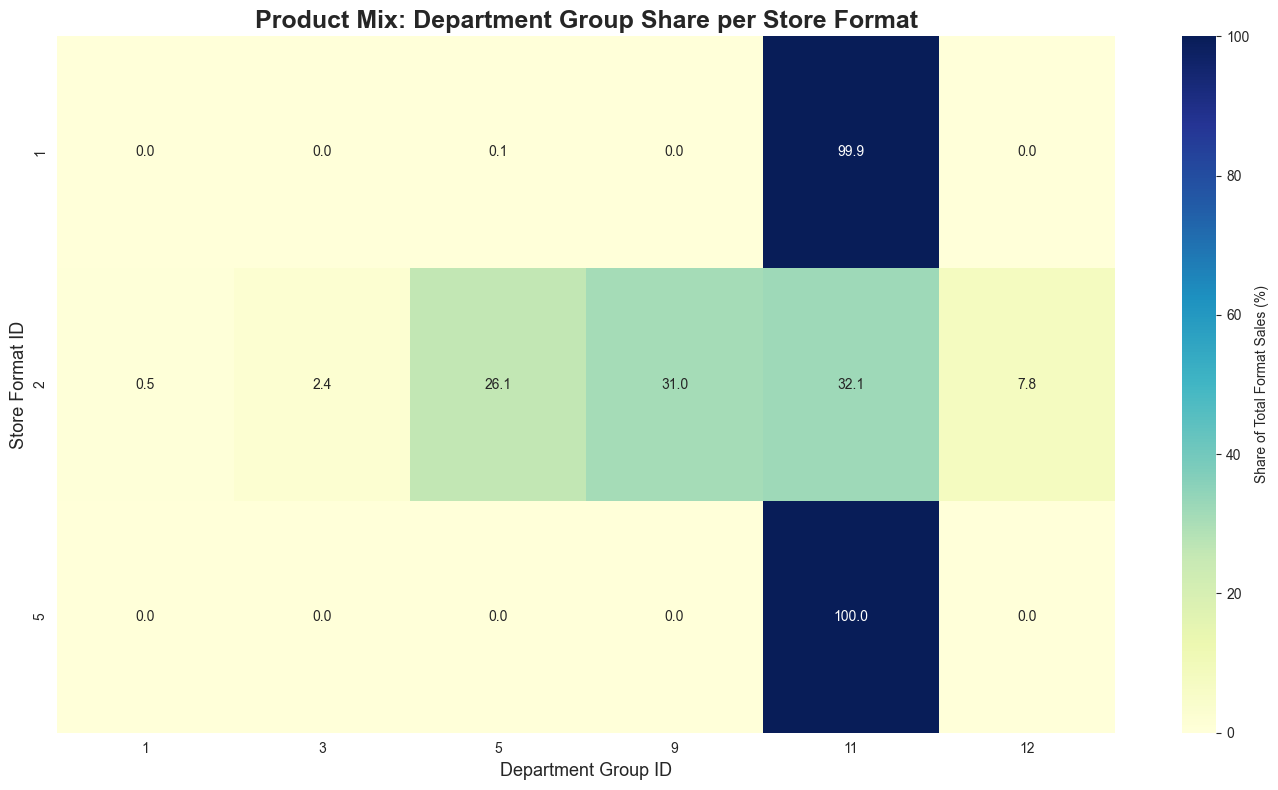

In [20]:
format_dept_sales = X_train_preprocessed.groupby(['store_format', 'department_group'])['sales'].sum().reset_index()

pivot_data = format_dept_sales.pivot(index='store_format', columns='department_group', values='sales').fillna(0)

pivot_norm = pivot_data.div(pivot_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(14, 8))
sns.heatmap(pivot_norm, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': 'Share of Total Format Sales (%)'})

plt.title('Product Mix: Department Group Share per Store Format', fontsize=18, fontweight='bold')
plt.xlabel('Department Group ID', fontsize=13)
plt.ylabel('Store Format ID', fontsize=13)

plt.tight_layout()
plt.savefig("images/product_mix_per_store_format.png")
plt.show()

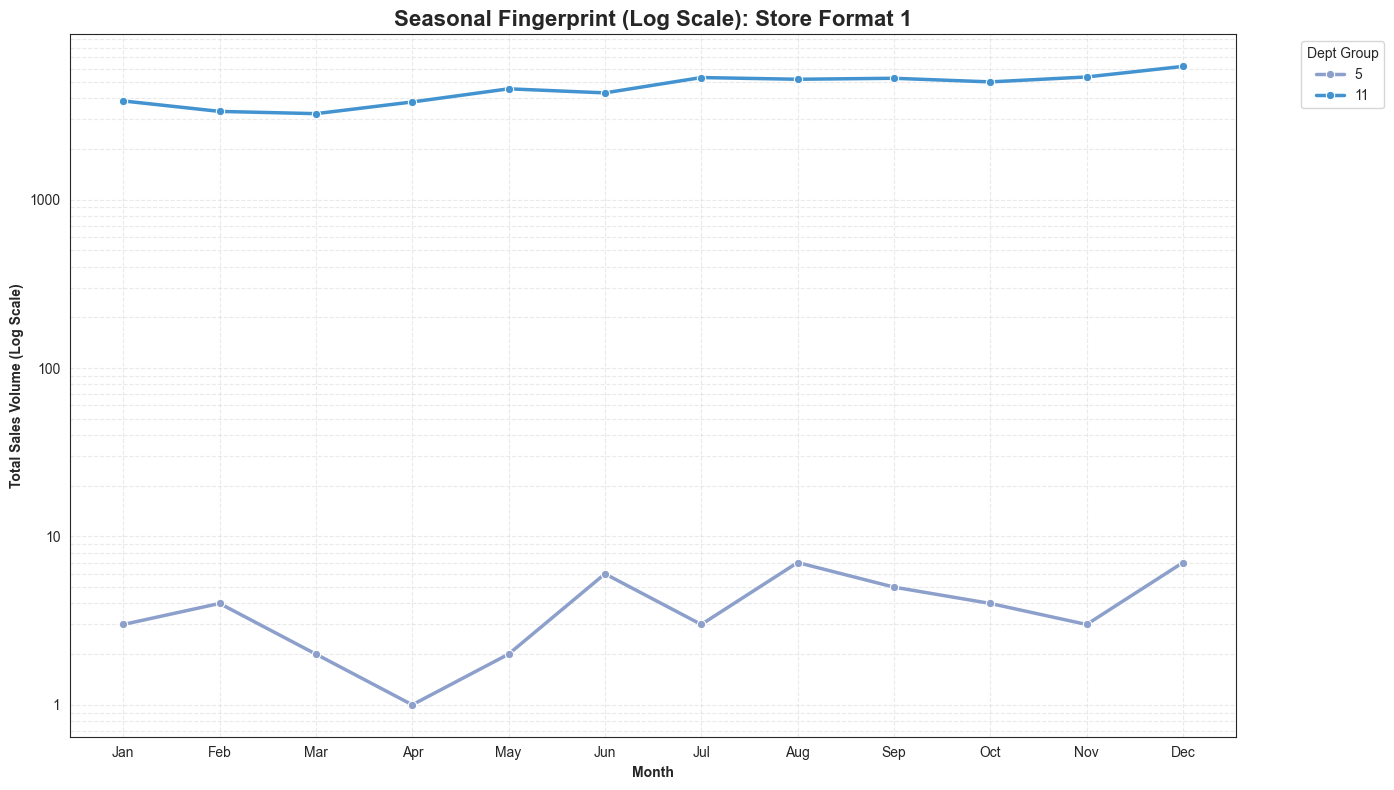

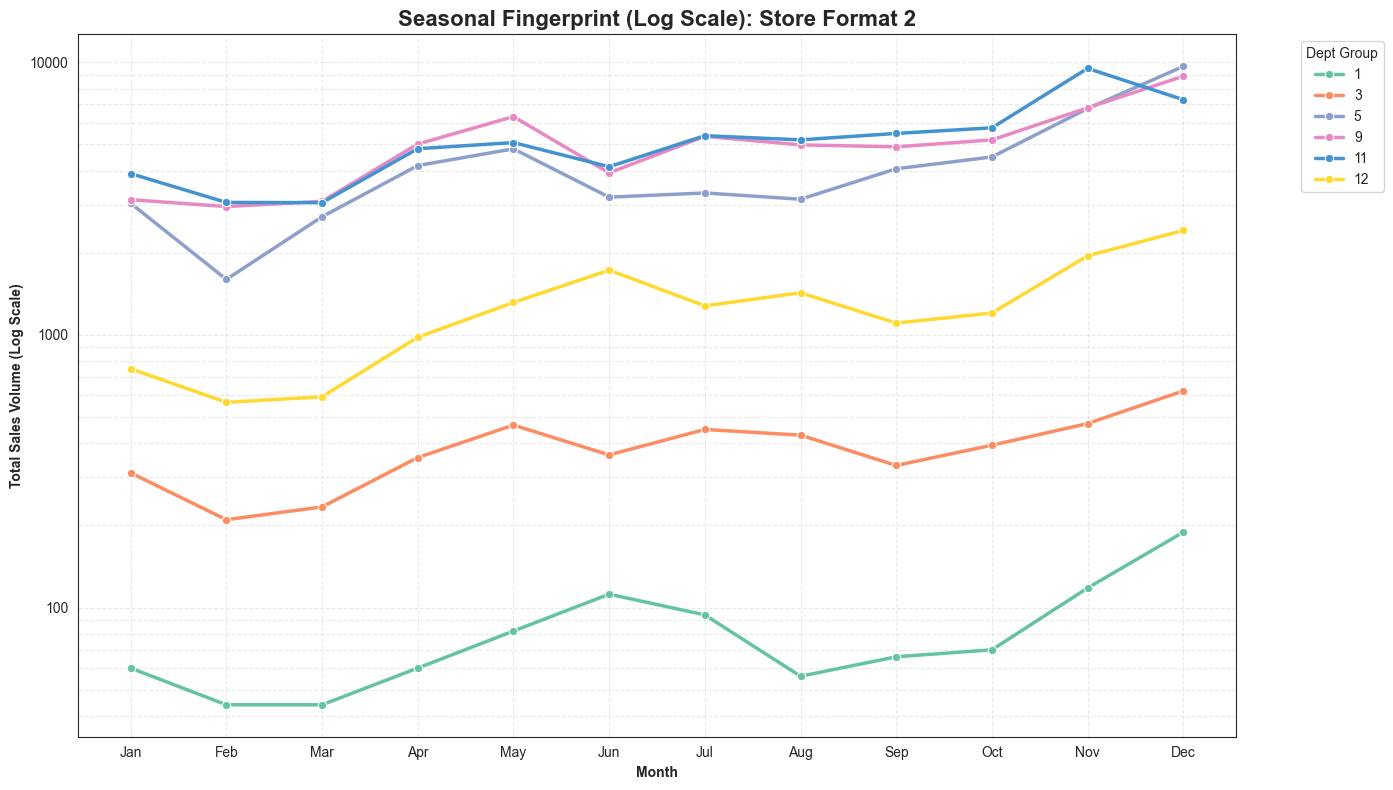

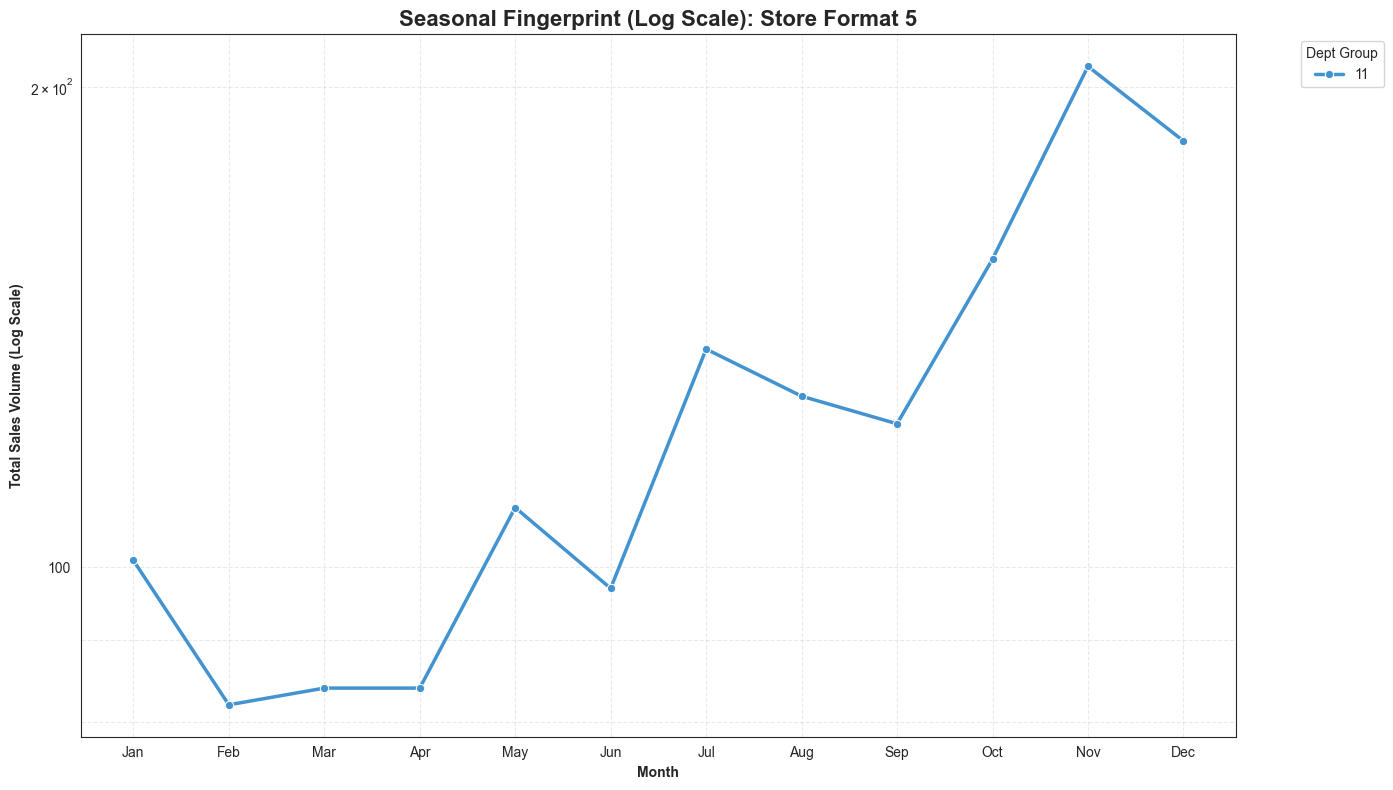

In [21]:
target_blue = "#4293D0"
all_depts = sorted(X_train_preprocessed['department_group'].unique())
base_colors = sns.color_palette("Set2", len(all_depts))
dept_color_map = {dept: base_colors[i] for i, dept in enumerate(all_depts)}

if 11 in dept_color_map:
    dept_color_map[11] = target_blue

unique_formats = sorted(X_train_preprocessed['store_format'].unique())

for fmt in unique_formats:
    format_data = X_train_preprocessed[X_train_preprocessed['store_format'] == fmt]
    fmt_seasonal = format_data.groupby(['department_group', 'month'])['sales'].sum().reset_index()

    plt.figure(figsize=(14, 8))
    
    sns.lineplot(
        data=fmt_seasonal,
        x='month',
        y='sales',
        hue='department_group',
        marker='o',
        linewidth=2.5,
        palette=dept_color_map
    )

    plt.yscale('log')
    
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter())
    plt.gca().yaxis.get_major_formatter().set_scientific(False)
    plt.gca().yaxis.get_major_formatter().set_useOffset(False)

    plt.title(f'Seasonal Fingerprint (Log Scale): Store Format {fmt}', fontsize=16, fontweight='bold')
    plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.ylabel('Total Sales Volume (Log Scale)', fontweight='bold')
    plt.xlabel('Month', fontweight='bold')
    
    plt.grid(True, which="both", linestyle='--', alpha=0.4)

    plt.legend(title='Dept Group', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    save_path = f'images/seasonal_fingerprint_store_format_{fmt}_log.png'
    plt.savefig(save_path)
    plt.show()

## Feature Engineering

In [22]:
X_train_engineered = data_loader.feature_engineering(X_train_preprocessed)
X_train_engineered.describe()

,store_number,product_number,product_category,business,department_num,department_group,store_format,week,sales,month,...,velocity,store_seasonal_avg,cat_seasonal_avg,dept_seasonal_avg,sales_log_return,prod_store_share,perf_vs_store,yoy_growth,weeks_to_eol,is_post_ces_launch
count,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058.000000,85058,85058.000000,85058.000000,...,69484.000000,72846.000000,59382.000000,84890.000000,75474.000000,7.607300e+04,65151.000000,5.391000e+04,85058.000000,85058.000000
mean,56.881469,137.766277,309149.320534,3091.442404,30.864775,9.001669,1.876461,2023-08-17 11:59:59.999999744,2.964413,6.866197,...,0.956172,2.842173,2.705913,2.965433,0.002152,8.359471e+05,1.022792,6.902806e+05,112.500000,0.070423
min,0.000000,0.000000,20318.000000,203.000000,2.000000,1.000000,1.000000,2022-04-11 00:00:00,0.000000,1.000000,...,0.000000,1.099567,0.000000,0.000000,-4.653960,0.000000e+00,0.000000,0.000000e+00,42.000000,0.000000
25%,60.000000,68.000000,200606.000000,2006.000000,20.000000,9.000000,2.000000,2022-12-12 00:00:00,0.000000,4.000000,...,0.500000,1.949153,0.833333,1.346237,-0.405465,0.000000e+00,0.000000,0.000000e+00,77.000000,0.000000
50%,61.000000,126.000000,301202.000000,3012.000000,30.000000,9.000000,2.000000,2023-08-17 12:00:00,1.000000,7.000000,...,0.934171,2.287719,1.266667,1.795745,0.000000,2.066116e-03,0.253472,6.363636e-01,112.500000,0.000000
75%,62.000000,209.000000,401001.000000,4010.000000,40.000000,11.000000,2.000000,2024-04-22 00:00:00,2.000000,10.000000,...,1.333332,2.946237,2.986395,4.728571,0.405465,9.174312e-03,0.784053,1.899998e+01,148.000000,0.000000
max,66.000000,296.000000,590001.000000,5900.000000,59.000000,12.000000,5.000000,2024-12-23 00:00:00,494.000000,12.000000,...,3.000000,26.333333,36.833333,15.558685,4.890349,2.500000e+08,302.548612,1.110000e+08,183.000000,1.000000
std,12.857362,83.702915,144710.632028,1447.119085,14.467367,2.700105,0.410341,NaN,10.595799,3.297968,...,0.661086,2.032836,3.611927,2.322635,0.725240,3.953342e+06,4.468564,2.603973e+06,40.991094,0.255859


In [23]:
"""import pandas as pd

# Assuming X_train_preprocessed is your DataFrame
output_filename = 'preprocessed_train_data.xlsx'

# Save to Excel
# index=False prevents pandas from writing the row numbers as a separate column
X_train_preprocessed.to_excel(output_filename, index=False)

print(f"Data successfully saved to {output_filename}")"""

'import pandas as pd\n\n# Assuming X_train_preprocessed is your DataFrame\noutput_filename = \'preprocessed_train_data.xlsx\'\n\n# Save to Excel\n# index=False prevents pandas from writing the row numbers as a separate column\nX_train_preprocessed.to_excel(output_filename, index=False)\n\nprint(f"Data successfully saved to {output_filename}")'

## Data Preparation for Model Training

In [24]:
date_col = data_loader.get_date_col()
target_col = data_loader.get_target_col()

X_train_engineered = X_train_engineered.sort_values(by=date_col)

X_train_chronos = X_train_engineered.copy()

X_train_full = X_train_engineered.drop(columns=[target_col, "week", "quarter", "week_of_year", "month"])
y_train_full = X_train_engineered[target_col]

# Define Categorical Data
categorical_features = [
    'store_number', 'product_number', 'product_category',
    'business', 'department_num', 'department_group',
    'store_format'
]

for col in categorical_features:
    if col in X_train_full.columns:
        X_train_full[col] = X_train_full[col].astype('category')

horizon = 15
x_fold_cv = 3

## Chronos-2 Model Performance

In [25]:
X_train_chronos['id'] = X_train_chronos['store_number'].astype(str) + '_' + X_train_chronos['product_number'].astype(str)

results = {}
final_models = {}

all_dates = sorted(X_train_chronos[date_col].unique())
cv_rmses = []

pipeline = Chronos2Pipeline.from_pretrained("amazon/chronos-2", device_map="mps")

useful_covariates = [
    'id', date_col,
    'week_sin', 'week_cos',
    'dept_seasonal_avg',
    'velocity',
    'yoy_growth'
]

print(f"\nStarting Cross-Validation for Chronos-2")

for i in range(x_fold_cv):
    test_start_idx = len(all_dates) - (horizon * (i + 1))
    test_end_idx = test_start_idx + horizon

    cutoff_date = all_dates[test_start_idx]
    end_date = all_dates[test_end_idx - 1]

    context_df = X_train_chronos[X_train_chronos[date_col] < cutoff_date].copy()
    context_df = context_df.groupby('id').tail(52)

    ground_truth = X_train_chronos[(X_train_chronos[date_col] >= cutoff_date) &
                                   (X_train_chronos[date_col] <= end_date)].copy()
    future_df = ground_truth.drop(columns=[target_col]).copy()

    future_df = ground_truth[useful_covariates].copy()

    # Generate Forecasts
    pred_df = pipeline.predict_df(
        context_df,
        future_df=future_df,
        prediction_length=horizon,
        quantile_levels=[0.5], # Median for point forecast
        id_column="id",
        timestamp_column=date_col,
        target=target_col,
        batch_size=64
    )

    comparison = ground_truth.merge(pred_df[['id', date_col, '0.5']], on=['id', date_col])
    window_rmse = root_mean_squared_error(comparison[target_col], comparison['0.5'])
    cv_rmses.append(window_rmse)

    print(f"Fold {i + 1}: Cutoff {cutoff_date.date()} | RMSE: {window_rmse:.4f}")

    if i == 0:
        final_models['Chronos-2'] = pipeline

# Final Evaluation
average_rmse_chronos = np.mean(cv_rmses)
results['Chronos-2'] = average_rmse_chronos
print(f"\nAverage CV RMSE for Chronos-2: {average_rmse_chronos:.4f}")


Starting Cross-Validation for Chronos-2
Fold 1: Cutoff 2024-09-16 | RMSE: 8.4244
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6664
Fold 3: Cutoff 2024-02-19 | RMSE: 5.4329

Average CV RMSE for Chronos-2: 5.8413


## Boost Model Performance

In [26]:
rows_per_week = X_train_engineered.groupby(date_col).size().iloc[0]
horizon_rows = int(rows_per_week * horizon)

tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)

# Cross-Validation Loop
models_to_test = ['CatBoost', 'XGBoost', 'LightGBM']

for model_name in models_to_test:
    fold_errors = []
    print(f"\nStarting Cross-Validation for {model_name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        val_dates = X_train_engineered.iloc[val_idx][date_col]

        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_name == 'CatBoost':
            m = CatBoostRegressor(
                iterations=1500, learning_rate=0.05, depth=6,
                loss_function='RMSE', random_seed=42, verbose=False,
                early_stopping_rounds=50
            )
            m.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))

        elif model_name == 'XGBoost':
            m = xgb.XGBRegressor(
                n_estimators=1500, learning_rate=0.05, max_depth=6,
                objective='reg:squarederror', enable_categorical=True,
                tree_method='hist', random_state=42, verbosity=0
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        elif model_name == 'LightGBM':
            m = lgb.LGBMRegressor(
                n_estimators=1500, learning_rate=0.05,
                objective='regression', metric='rmse',
                random_state=42, verbose=-1
            )
            m.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(50)])

        # Calculate RMSE for this fold
        fold_rmse = root_mean_squared_error(y_va, m.predict(X_va))
        fold_errors.append(fold_rmse)

        print(f"Fold {fold + 1}: Cutoff {val_dates.min().date()} | RMSE: {fold_rmse:.4f}")

        # Store the model and data from the latest fold
        if fold == tscv.n_splits - 1:
            final_models[model_name] = m
            X_val_final, y_val_final, val_dates_final = X_va, y_va, val_dates

    results[model_name] = np.mean(fold_errors)
    print(f"\nAverage CV RMSE for {model_name}: {results[model_name]:.4f}")

# Final Results
winner_name = min(results, key=results.get)

cat_model = final_models.get('CatBoost')
xgb_model = final_models.get('XGBoost')
lgb_model = final_models.get('LightGBM')


Starting Cross-Validation for CatBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 5.0923
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3762
Fold 3: Cutoff 2024-09-16 | RMSE: 7.3977

Average CV RMSE for CatBoost: 5.2887

Starting Cross-Validation for XGBoost
Fold 1: Cutoff 2024-02-19 | RMSE: 5.4157
Fold 2: Cutoff 2024-06-03 | RMSE: 3.6710
Fold 3: Cutoff 2024-09-16 | RMSE: 8.7159

Average CV RMSE for XGBoost: 5.9342

Starting Cross-Validation for LightGBM
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[119]	valid_0's rmse: 5.23325
Fold 1: Cutoff 2024-02-19 | RMSE: 5.2332
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 3.36482
Fold 2: Cutoff 2024-06-03 | RMSE: 3.3648
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[128]	valid_0's rmse: 8.06854
Fold 3: Cutoff 2024-09-16 | RMSE: 8.0685

Average CV RMSE for LightGBM: 5.5555


## Results

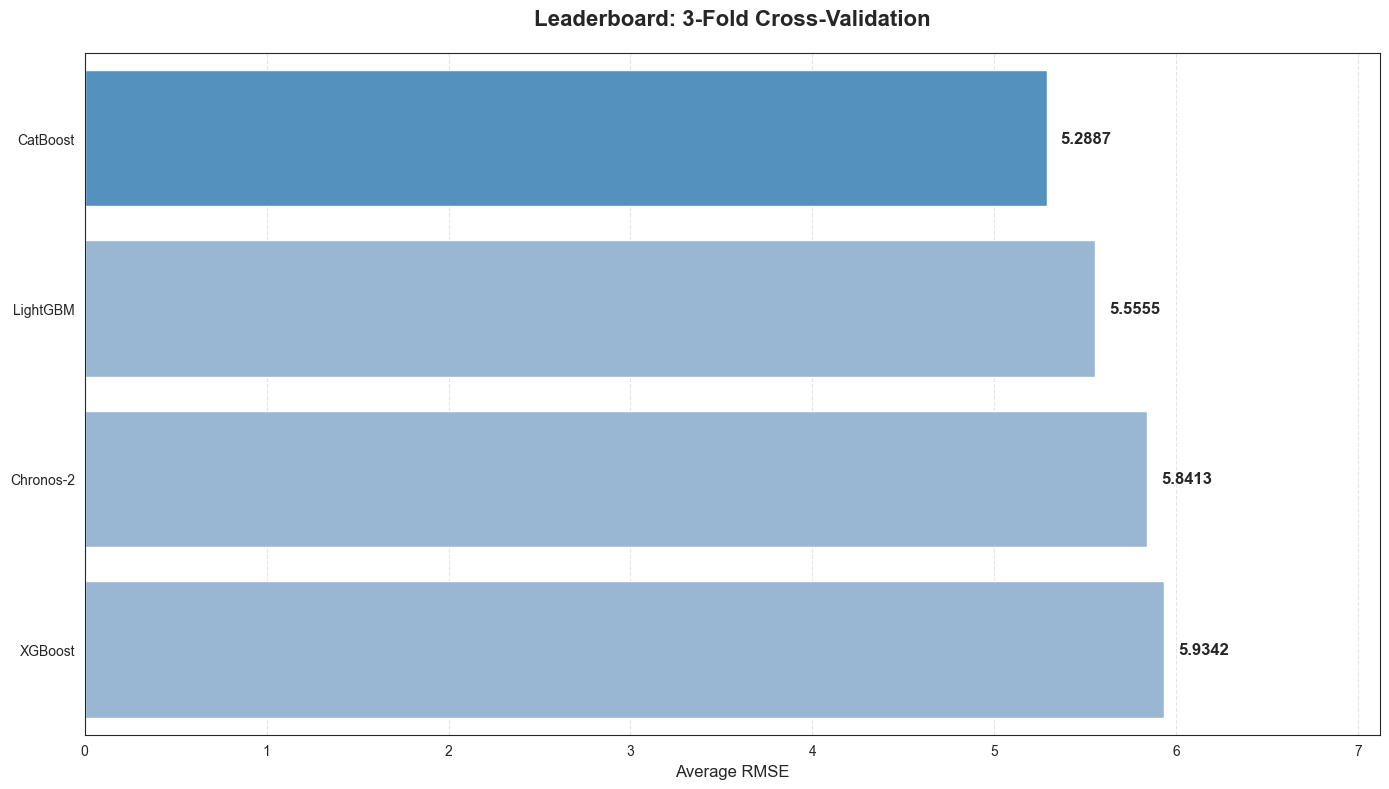

Overall Champion: CatBoost


In [27]:
df_leaderboard = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE'])
df_leaderboard = df_leaderboard.sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))
winner_overall = df_leaderboard.iloc[0]['Model']
colors = [target_blue if model == winner_overall else '#8FB7DD' for model in df_leaderboard['Model']]

ax = sns.barplot(
    data=df_leaderboard,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

# Bar Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title('Leaderboard: 3-Fold Cross-Validation', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=12)
plt.ylabel('', fontsize=12)
plt.xlim(0, df_leaderboard['RMSE'].max() * 1.2)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('images/model_leaderboard.png')
plt.show()

print(f"Overall Champion: {winner_overall}")

In [28]:
"""def objective(trial):
    # Suggest the model type first
    model_type = trial.suggest_categorical('model_type', models_to_test)

    # Shared or model-specific parameters
    n_estimators = trial.suggest_int('n_estimators', 100, 2000, step=100)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    depth = trial.suggest_int('max_depth', 3, 8)
    l2_reg = trial.suggest_float('l2_reg', 1e-2, 10.0, log=True)

    tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)
    cv_scores = []
    fold_best_ntrees = []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):
        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]
        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]

        if model_type == 'XGBoost':
            model = xgb.XGBRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=n_estimators, early_stopping_rounds=30,
                tree_method='hist', enable_categorical=True,
                random_state=42, verbosity=0
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)
            fold_best_ntrees.append(model.best_iteration)

        elif model_type == 'CatBoost':
            model = CatBoostRegressor(
                learning_rate=learning_rate, depth=depth, l2_leaf_reg=l2_reg,
                iterations=n_estimators, early_stopping_rounds=30,
                random_seed=42, verbose=False
            )
            model.fit(X_tr, y_tr, cat_features=categorical_features, eval_set=(X_va, y_va))
            fold_best_ntrees.append(model.get_best_iteration())

        elif model_type == 'LightGBM':
            model = lgb.LGBMRegressor(
                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,
                n_estimators=n_estimators, random_state=42, verbose=-1
            )
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], callbacks=[lgb.early_stopping(30)])
            fold_best_ntrees.append(model.best_iteration_)

        score = root_mean_squared_error(y_va, model.predict(X_va))
        cv_scores.append(score)

        trial.report(np.mean(cv_scores), step=fold)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Save the best iteration average so we can retrain later
    avg_ntree = int(np.mean(fold_best_ntrees))
    trial.set_user_attr("best_ntree", avg_ntree)

    return np.mean(cv_scores)

study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(multivariate=True, seed=42),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=3, reduction_factor=3
    )
)

study.optimize(objective, n_trials=100)"""

'def objective(trial):\n    # Suggest the model type first\n    model_type = trial.suggest_categorical(\'model_type\', models_to_test)\n\n    # Shared or model-specific parameters\n    n_estimators = trial.suggest_int(\'n_estimators\', 100, 2000, step=100)\n    learning_rate = trial.suggest_float(\'learning_rate\', 0.01, 0.1, log=True)\n    depth = trial.suggest_int(\'max_depth\', 3, 8)\n    l2_reg = trial.suggest_float(\'l2_reg\', 1e-2, 10.0, log=True)\n\n    tscv = TimeSeriesSplit(n_splits=x_fold_cv, test_size=horizon_rows)\n    cv_scores = []\n    fold_best_ntrees = []\n\n    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train_full)):\n        X_tr, X_va = X_train_full.iloc[train_idx], X_train_full.iloc[val_idx]\n        y_tr, y_va = y_train_full.iloc[train_idx], y_train_full.iloc[val_idx]\n\n        if model_type == \'XGBoost\':\n            model = xgb.XGBRegressor(\n                learning_rate=learning_rate, max_depth=depth, reg_lambda=l2_reg,\n                n_esti

In [29]:
"""def get_best_per_model(study):
    results = {}
    
    # Wir betrachten nur abgeschlossene Versuche (nicht abgebrochene/geprunte)
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    
    for model_name in models_to_test:
        # Filter trials für diesen speziellen Modelltyp
        model_trials = [t for t in completed_trials if t.params.get('model_type') == model_name]
        
        if model_trials:
            # Finde den Trial mit dem minimalen Wert (RMSE)
            best_model_trial = min(model_trials, key=lambda t: t.value)
            
            results[model_name] = {
                "params": best_model_trial.params,
                "value": best_model_trial.value,
                "best_ntree": best_model_trial.user_attrs.get("best_ntree")
            }
            
    return results

best_per_model = get_best_per_model(study)

for model_name, data in best_per_model.items():
    print(f"\nBest result for {model_name}")
    print(f"RMSE: {data['value']:.4f}")
    print(f"Best ntrees (avg): {data['best_ntree']}")
    print(f"Parameter: {data['params']}")"""

'def get_best_per_model(study):\n    results = {}\n\n    # Wir betrachten nur abgeschlossene Versuche (nicht abgebrochene/geprunte)\n    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]\n\n    for model_name in models_to_test:\n        # Filter trials für diesen speziellen Modelltyp\n        model_trials = [t for t in completed_trials if t.params.get(\'model_type\') == model_name]\n\n        if model_trials:\n            # Finde den Trial mit dem minimalen Wert (RMSE)\n            best_model_trial = min(model_trials, key=lambda t: t.value)\n\n            results[model_name] = {\n                "params": best_model_trial.params,\n                "value": best_model_trial.value,\n                "best_ntree": best_model_trial.user_attrs.get("best_ntree")\n            }\n\n    return results\n\nbest_per_model = get_best_per_model(study)\n\nfor model_name, data in best_per_model.items():\n    print(f"\nBest result for {model_name}")\n    print(f"

/var/folders/f2/2y22t7gx2z5gdwk3d89ytmy00000gn/T/ipykernel_80669/655503071.py:21: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  ax = sns.barplot(


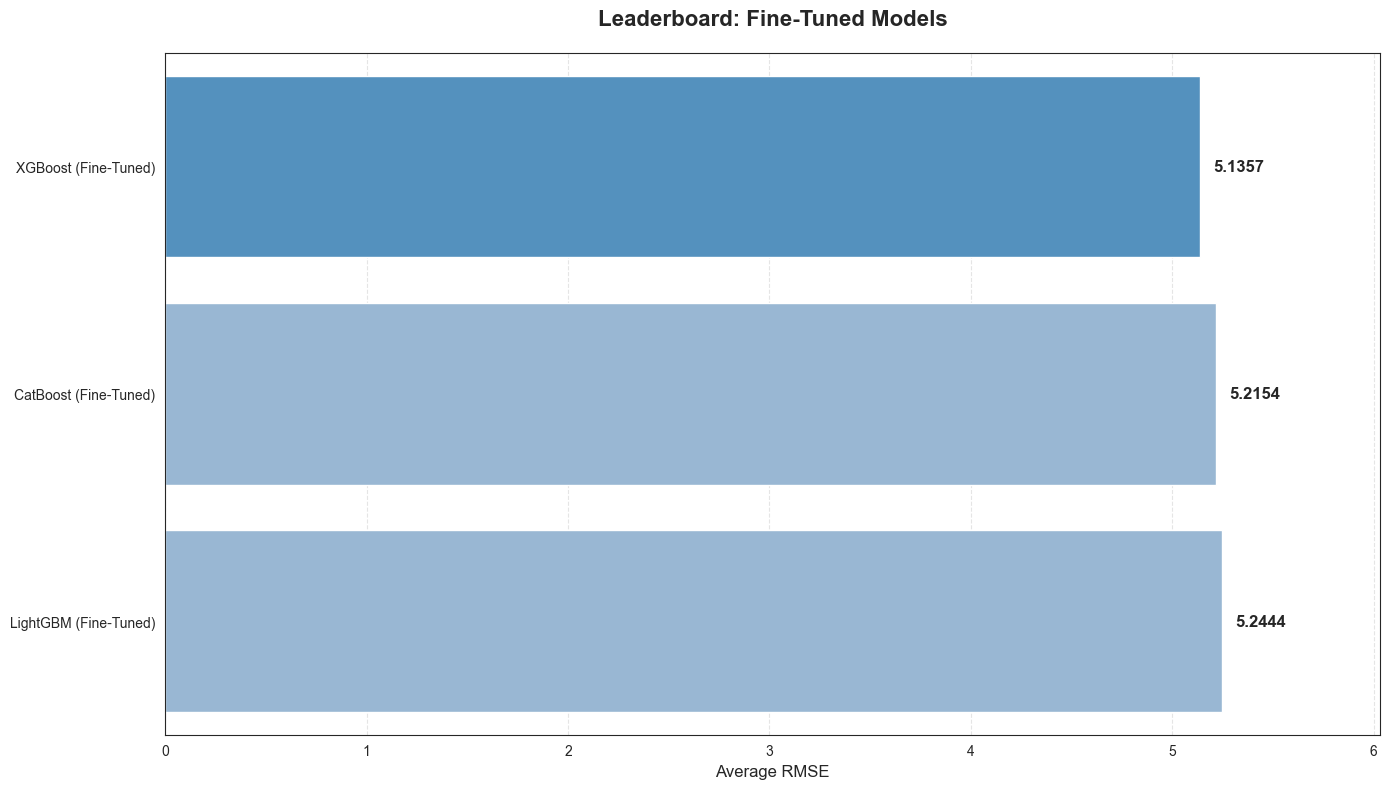

In [30]:
with open('config/best_models_config.json', 'r') as f:
    config_data = json.load(f)

saved_models = config_data['models']
experiment_winner = config_data['metadata']['overall_winner']

final_leaderboard_data = []

for model_name, details in saved_models.items():
    final_leaderboard_data.append({
        'Model': f"{model_name} (Fine-Tuned)",
        'RMSE': details['rmse'],
        'Is_Tuned': True
    })

df_final = pd.DataFrame(final_leaderboard_data).sort_values(by='RMSE', ascending=True)

plt.figure(figsize=(14, 8))


ax = sns.barplot(
    data=df_final,
    x='RMSE',
    y='Model',
    palette=colors,
    hue='Model',
    legend=False
)

for i in ax.containers:
    ax.bar_label(i, fmt='%.4f', padding=10, fontsize=12, fontweight='bold')

plt.title(f'Leaderboard: Fine-Tuned Models', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Average RMSE', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.xlim(0, df_final['RMSE'].max() * 1.15)

plt.tight_layout()
plt.savefig('images/model_leaderboard_fine_tuned.png')
plt.show()

In [31]:
fine_tuned_winner = config_data['metadata']['overall_winner']
winner_data = config_data['models'][fine_tuned_winner]

best_params = winner_data['params'].copy()
best_ntree = winner_data['best_ntree']

print(f"Best Model Type from Config: {fine_tuned_winner}")
print(f"Best iteration count: {best_ntree}")

if fine_tuned_winner == 'XGBoost':
    final_model = xgb.XGBRegressor(
        **best_params,
        enable_categorical=True
    )

elif fine_tuned_winner == 'CatBoost':
    final_model = CatBoostRegressor(
        **best_params,
        cat_features=categorical_features
    )

elif fine_tuned_winner == 'LightGBM':
    final_model = lgb.LGBMRegressor(
        **best_params
    )

final_model.fit(X_train_full, y_train_full)

print(f"Final training of {fine_tuned_winner} completed using saved hyperparameters.")

Best Model Type from Config: XGBoost
Best iteration count: 286
Final training of XGBoost completed using saved hyperparameters.


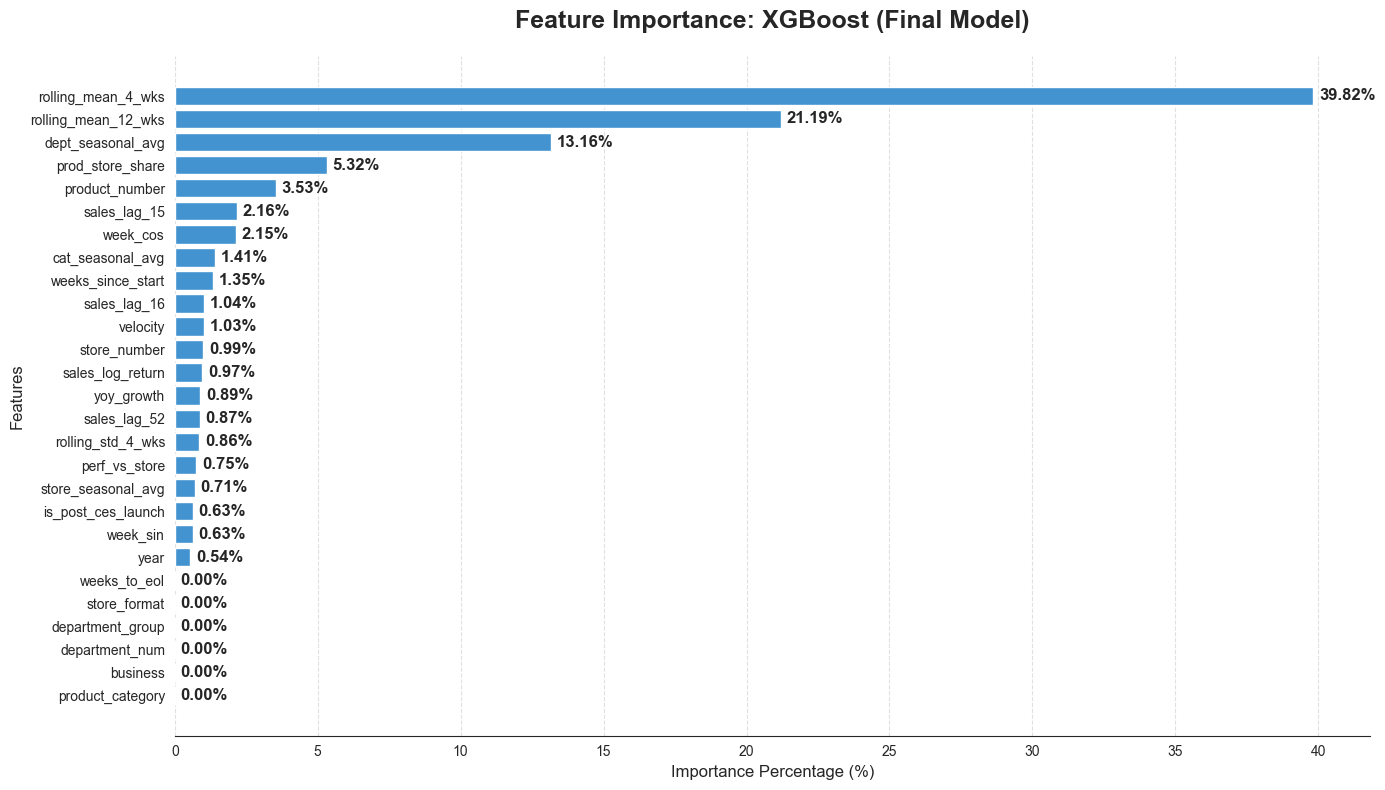

In [32]:
feature_names = X_train_full.columns

if fine_tuned_winner == 'CatBoost':
    importances = final_model.get_feature_importance()
elif fine_tuned_winner == 'XGBoost':
    importances = final_model.feature_importances_
elif fine_tuned_winner == 'LightGBM':
    importances = final_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df['Importance'] = (importance_df['Importance'] / importance_df['Importance'].sum()) * 100
importance_df = importance_df.sort_values(by='Importance', ascending=True)

plt.figure(figsize=(14, 8)) 
plt.barh(importance_df['Feature'], importance_df['Importance'], color=target_blue)

plt.title(f'Feature Importance: {fine_tuned_winner} (Final Model)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Importance Percentage (%)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 0.2, index, f'{value:.2f}%', va='center', fontsize=12, fontweight='bold')

sns.despine(left=True)
plt.tight_layout()

save_path = f"images/feature_importance_{fine_tuned_winner.lower()}.png"
plt.savefig(save_path, dpi=300)
plt.show()

## Test Data

In [33]:
# Prepare the test data
X_test_engineered = data_loader.prepare_test_features(df["train"], df["test"])

# Align the columns with the training data
feature_cols = X_train_full.columns.tolist()
X_test_predict = X_test_engineered[feature_cols].copy()

# Align Categorical Dtypes
if fine_tuned_winner != 'CatBoost':
    for col in categorical_features:
        if col in X_test_predict.columns:
            X_test_predict[col] = X_test_predict[col].astype(X_train_full[col].dtype)

            X_test_predict[col] = X_test_predict[col].where(
                X_test_predict[col].isin(X_train_full[col].cat.categories)
            )

# Verify no column-order mismatch (XGBoost requires columns in same order as training)
X_test_predict = X_test_predict[X_train_full.columns]

# Generate Final Predictions
test_predictions = final_model.predict(X_test_predict)

# Post-Processing
test_predictions = np.maximum(test_predictions, 0)

df_results = X_test_engineered[['store_number', 'product_number', 'product_category', 'business', 'department_num', 'department_group', 'store_format', 'week']].copy()
df_results['sales'] = test_predictions

df_results_preprocessed = data_loader.preprocessing(df_results)

output_path = f'results/final_sales_predictions.xlsx'
df_results.to_excel(output_path, index=False)

print(f"Predictions saved to {output_path}")
print(df_results.head())

Predictions saved to results/final_sales_predictions.xlsx
     store_number  product_number  product_category  business  department_num  \
142             0             126            301202      3012              30   
143             0             126            301202      3012              30   
144             0             126            301202      3012              30   
145             0             126            301202      3012              30   
146             0             126            301202      3012              30   

     department_group  store_format       week     sales  
142                11             1 2024-12-30  2.250633  
143                11             1 2025-01-06  1.204191  
144                11             1 2025-01-13  1.470413  
145                11             1 2025-01-20  1.668393  
146                11             1 2025-01-27  1.978766  


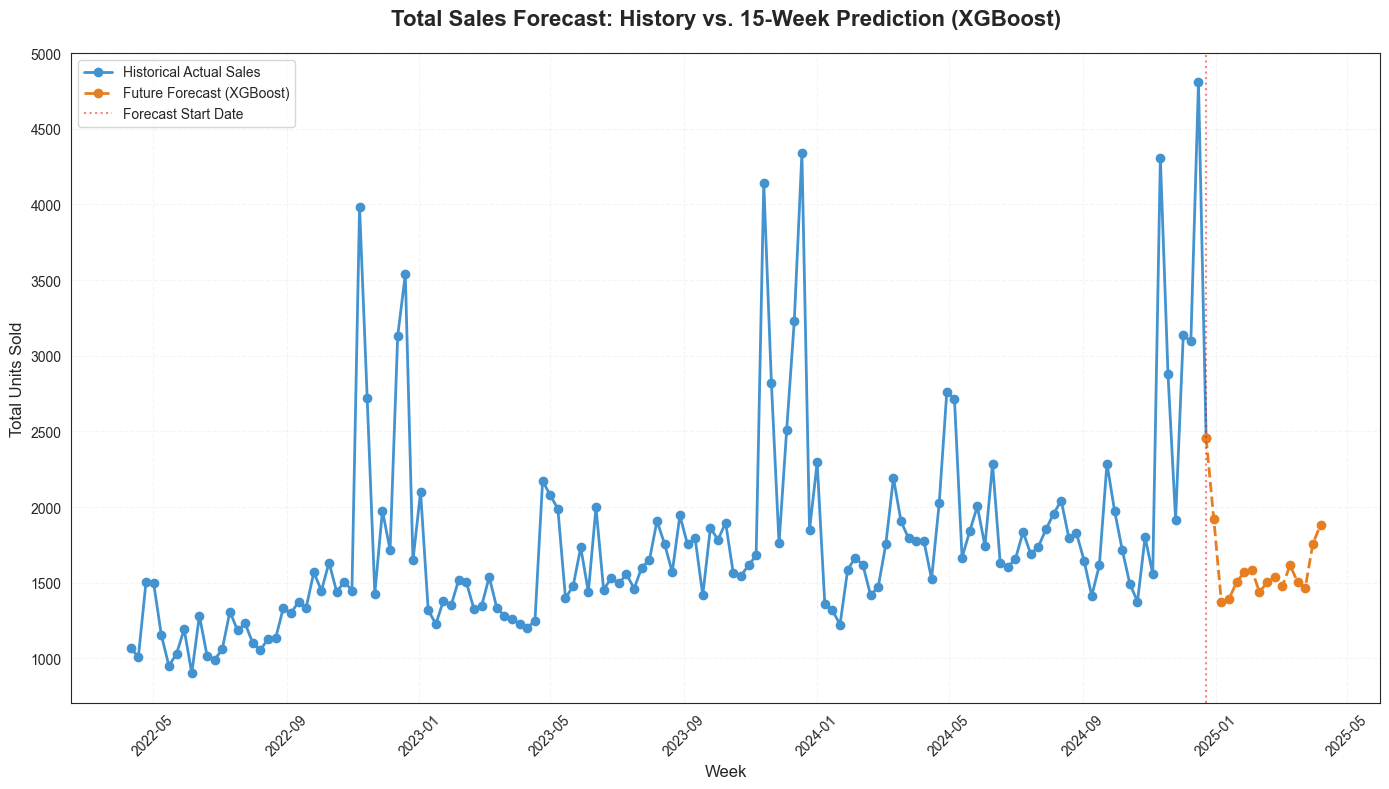

In [34]:
# Prepare Historical Data
history_weeks = data_loader.preprocessing(df['train'])['week']
df_history = pd.DataFrame({
    'week': history_weeks.loc[X_train_full.index],
    'sales': y_train_full
})
weekly_actuals = df_history.groupby('week')['sales'].sum().reset_index().sort_values('week')

weekly_forecast = df_results.groupby('week')['sales'].sum().reset_index().sort_values('week')

# Get the very last point of history
last_actual_point = weekly_actuals.tail(1)

# Attach it to the start of the forecast
weekly_forecast_connected = pd.concat([last_actual_point, weekly_forecast], ignore_index=True)

plt.figure(figsize=(14, 8))

# Plot Historical Sales
plt.plot(weekly_actuals['week'], weekly_actuals['sales'],
         label='Historical Actual Sales', color='#4293D0', linewidth=2, marker='o')

# Plot the Future
plt.plot(weekly_forecast_connected['week'], weekly_forecast_connected['sales'],
         label=f'Future Forecast ({fine_tuned_winner})', color='#e67e22', linestyle='--', linewidth=2, marker='o')

# Split Line
today = weekly_actuals['week'].max()
plt.axvline(x=today, color='red', linestyle=':', alpha=0.5, label='Forecast Start Date')

# Chart Styling
plt.title(f"Total Sales Forecast: History vs. 15-Week Prediction ({fine_tuned_winner})", fontsize=16, pad=20, fontweight='bold')
plt.xlabel("Week", fontsize=12)
plt.ylabel("Total Units Sold", fontsize=12)
plt.legend(loc='upper left', frameon=True)
plt.grid(True, linestyle='--', alpha=0.2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('images/sales_forecast_connected.png')
plt.show()

## Trends in Forecast Data

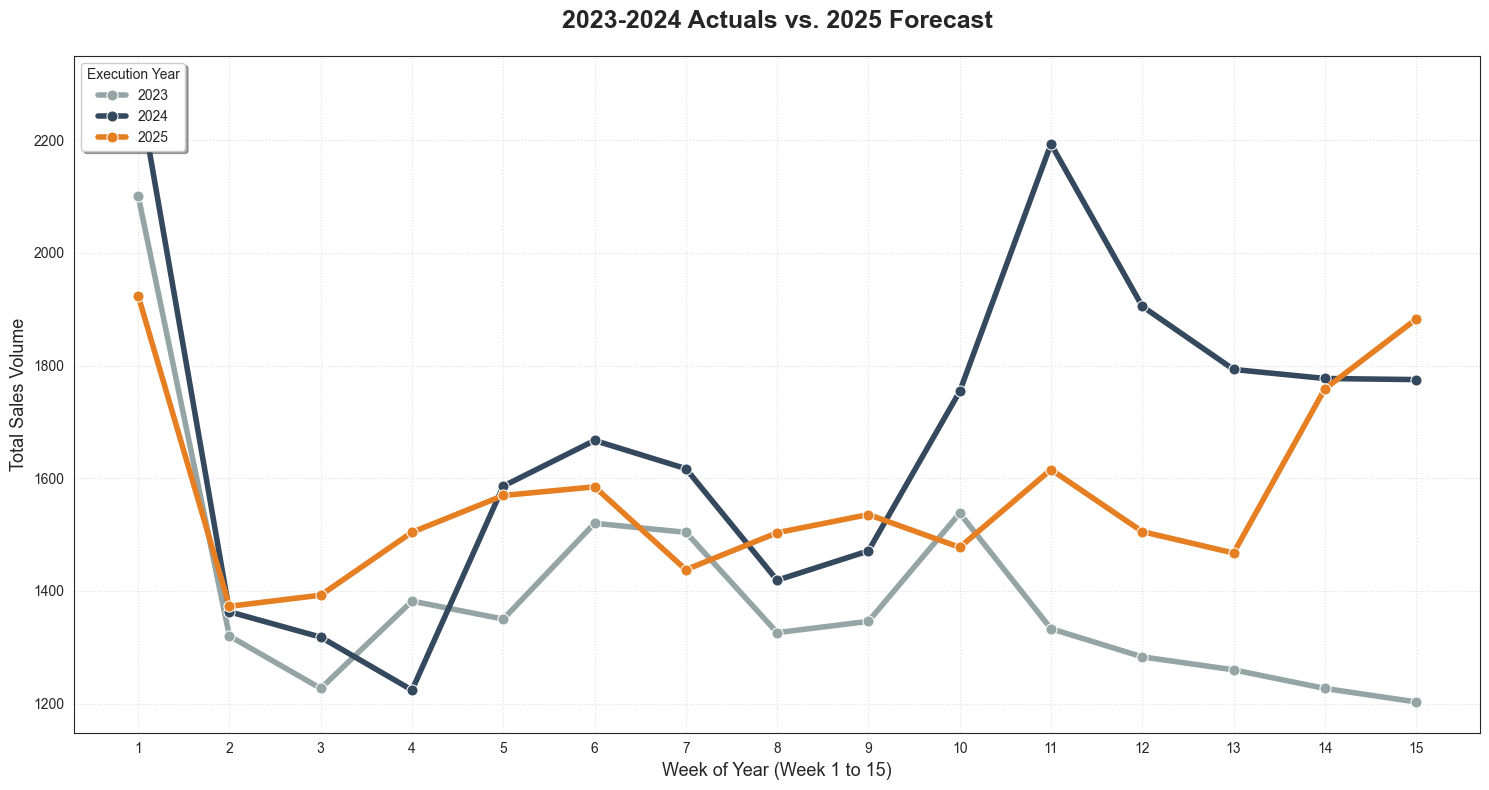

In [35]:
# Historical Data
history = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
history['week_num'] = history['week_of_year']

# Group historical sales
history_q1 = history[history['week_num'] <= 15].groupby(['year', 'week_num'])['sales'].sum().reset_index()

# Prepare Forecast Data
forecast = df_results_preprocessed.copy()
forecast['week_num'] = forecast['week_of_year']

# Group forecast sales
forecast_q1 = forecast.groupby(['year', 'week_num'])['sales'].sum().reset_index()
forecast_q1.columns = ['year', 'week_num', 'sales']

# Combine Actuals and Forecast
comparison_df = pd.concat([history_q1, forecast_q1])

plt.figure(figsize=(15, 8))

# Define a clear color palette: 2023 (Light), 2024 (Dark), 2025 (Highlight)
custom_palette = {2023: '#95a5a6', 2024: '#34495e', 2025: '#e67e22'}

sns.lineplot(
    data=comparison_df,
    x='week_num',
    y='sales',
    hue='year',
    palette=custom_palette,
    linewidth=4,
    marker='o',
    markersize=8
)

# Chart Styling
plt.title('2023-2024 Actuals vs. 2025 Forecast', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Week of Year (Week 1 to 15)', fontsize=13)
plt.ylabel('Total Sales Volume', fontsize=13)
plt.xticks(range(1, 16))
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Execution Year", loc='upper left', frameon=True, shadow=True)

plt.tight_layout()
plt.savefig("images/benchmark_yoy.png")
plt.show()

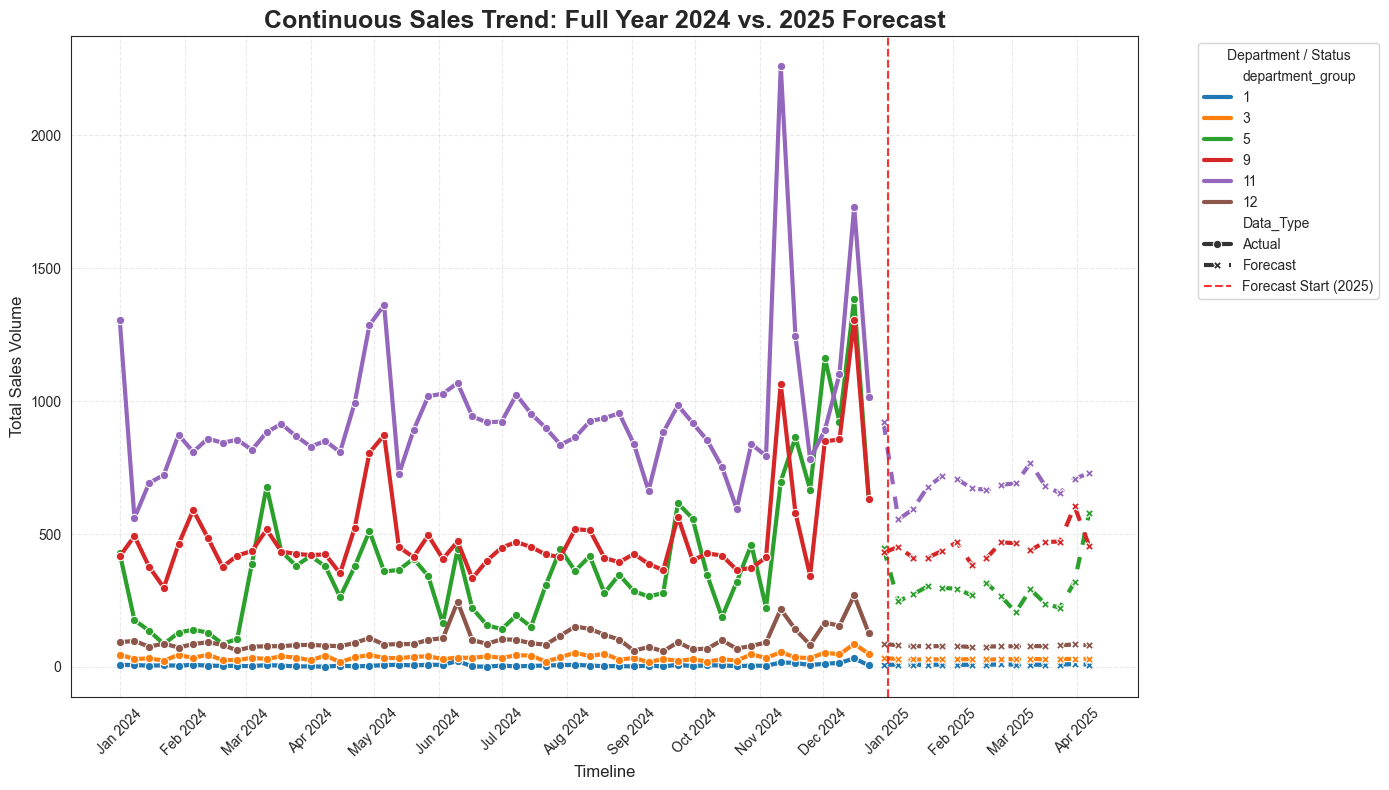

In [36]:
target_col = data_loader.get_target_col()
date_col = data_loader.get_date_col()

history_df = X_train_engineered.copy()

# Filter for the year 2024 to keep the transition clear
history_2024 = history_df[history_df[date_col].dt.year == 2024].copy()

# Group by date and department to get the total volume per week
seasonal_sum = history_2024.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
seasonal_sum['Data_Type'] = 'Actual'

# Create a copy of the test features and add final predictions
X_test_plot = X_test_engineered.copy()
X_test_plot[target_col] = test_predictions

# Group by date and department
forecast_sum = X_test_plot.groupby([date_col, 'department_group'])[target_col].sum().reset_index()
forecast_sum['Data_Type'] = 'Forecast'

combined_plot_data = pd.concat([seasonal_sum, forecast_sum], axis=0).sort_values(by=date_col)

plt.figure(figsize=(14, 8))

# Lineplot with different styles for Actual vs Forecast
sns.lineplot(
    data=combined_plot_data,
    x=date_col,
    y=target_col,
    hue='department_group',
    style='Data_Type',
    markers=True,
    dashes={'Actual': '', 'Forecast': (3, 3)},
    linewidth=3,
    palette="tab10"
)

# Add a vertical line for the New Year transition
plt.axvline(pd.Timestamp('2025-01-01'), color='red', linestyle='--', alpha=0.8, label='Forecast Start (2025)')

# Formatting
plt.title('Continuous Sales Trend: Full Year 2024 vs. 2025 Forecast', fontsize=18, fontweight='bold')
plt.ylabel('Total Sales Volume', fontsize=12)
plt.xlabel('Timeline', fontsize=12)

# Format the X-axis to show Month and Year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title='Department / Status', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("images/sales_trend_per_department.png")
plt.show()

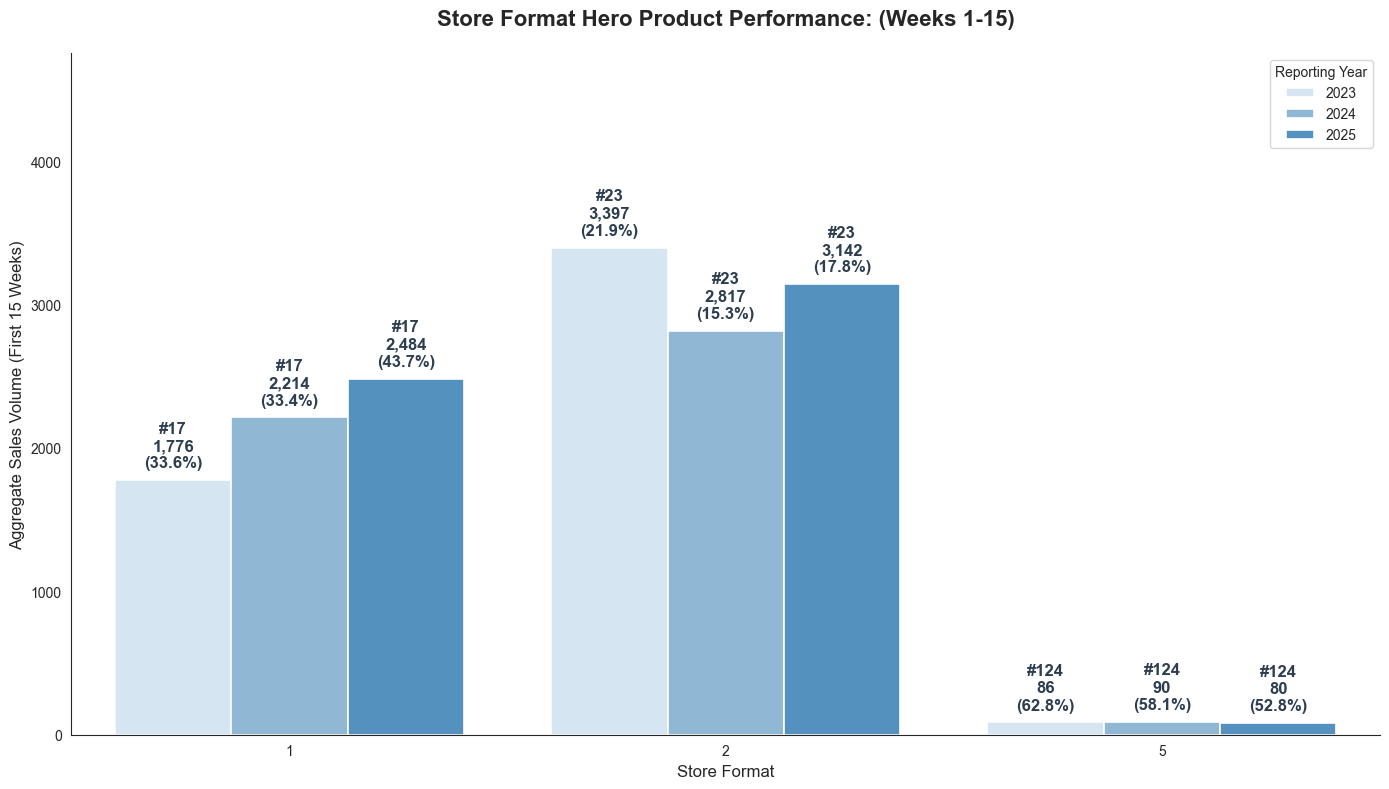

In [37]:
# Merge historical sales data for 2023 and 2024
actual_full = X_train_preprocessed[X_train_preprocessed['year'].isin([2023, 2024])].copy()
actual_full['sales'] = y_train_full.loc[actual_full.index]

# Filter for the first 15 weeks of the year using the 'week_of_year' column
df_history_15w = actual_full[actual_full['week_of_year'] <= 15].copy()

# Prepare Forecast data for 2025 - also filter for the first 15 weeks to ensure consistency
df_forecast_15w = df_results_preprocessed[df_results_preprocessed['week_of_year'] <= 15].copy()
df_forecast_15w['year'] = 2025

def get_hero_stats(df, period_label):
    """
    Identifies the top-selling product (Hero) per store format and calculates its share.
    """
    # Calculate total sales per year/format (the denominator for share calculation)
    format_totals = df.groupby(['year', 'store_format'])['sales'].sum().reset_index().rename(columns={'sales': 'total_sales'})
    
    # Identify the "Hero" product (ranked #1 by sales volume)
    heroes = (
        df.groupby(['year', 'store_format', 'product_number'])['sales']
        .sum().reset_index()
        .sort_values(['year', 'store_format', 'sales'], ascending=[True, True, False])
        .groupby(['year', 'store_format']).head(1)
    )
    
    # Merge with total sales to calculate the percentage share within the format
    heroes = heroes.merge(format_totals, on=['year', 'store_format'])
    heroes['share_pct'] = (heroes['sales'] / heroes['total_sales']) * 100
    heroes['Period'] = period_label
    return heroes

# Calculate statistics for historical years and the forecast
hero_23_24 = get_hero_stats(df_history_15w, "Actuals (Weeks 1-15)")
hero_25 = get_hero_stats(df_forecast_15w, "2025 Forecast (15 weeks)")

comparison_df = pd.concat([hero_23_24, hero_25]).sort_values(['store_format', 'year'])

plt.figure(figsize=(14, 8))
sns.set_style("white")

palette = {2023: "#D0E6F7", 2024: "#84B9E0", 2025: "#4293D0"}

ax = sns.barplot(
    data=comparison_df, 
    x='store_format', 
    y='sales', 
    hue='year', 
    palette=palette,
    edgecolor='white',
    linewidth=1.2
)

# Robust annotations for product number, Sales Volume, and Market Share
formats = comparison_df['store_format'].unique()
years = sorted(comparison_df['year'].unique())

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        year_idx = i // len(formats)
        fmt_idx = i % len(formats)
        
        current_year = years[year_idx]
        current_fmt = formats[fmt_idx]
        
        # Retrieve the specific data row for annotation
        row = comparison_df[
            (comparison_df['store_format'] == current_fmt) & 
            (comparison_df['year'] == current_year)
        ]
        
        if not row.empty:
            sku_num = row['product_number'].values[0]
            share = row['share_pct'].values[0]
            
            plt.text(
                p.get_x() + p.get_width() / 2., 
                height + (comparison_df['sales'].max() * 0.02),
                f'#{int(sku_num)}\n{int(height):,}\n({share:.1f}%)',
                ha='center', va='bottom', 
                fontsize=12, fontweight='bold', color='#2c3e50'
            )

# Final chart styling for professional presentation
plt.title('Store Format Hero Product Performance: (Weeks 1-15)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Store Format', fontsize=12)
plt.ylabel('Aggregate Sales Volume (First 15 Weeks)', fontsize=12)
plt.legend(title='Reporting Year', loc='upper right', frameon=True)

# Adjust y-axis limit to provide space for annotations
plt.ylim(0, comparison_df['sales'].max() * 1.4)
sns.despine()
plt.tight_layout()

# Save the plot for the final report
plt.savefig('images/hero_performance_comparison_store_format.png', dpi=300)
plt.show()

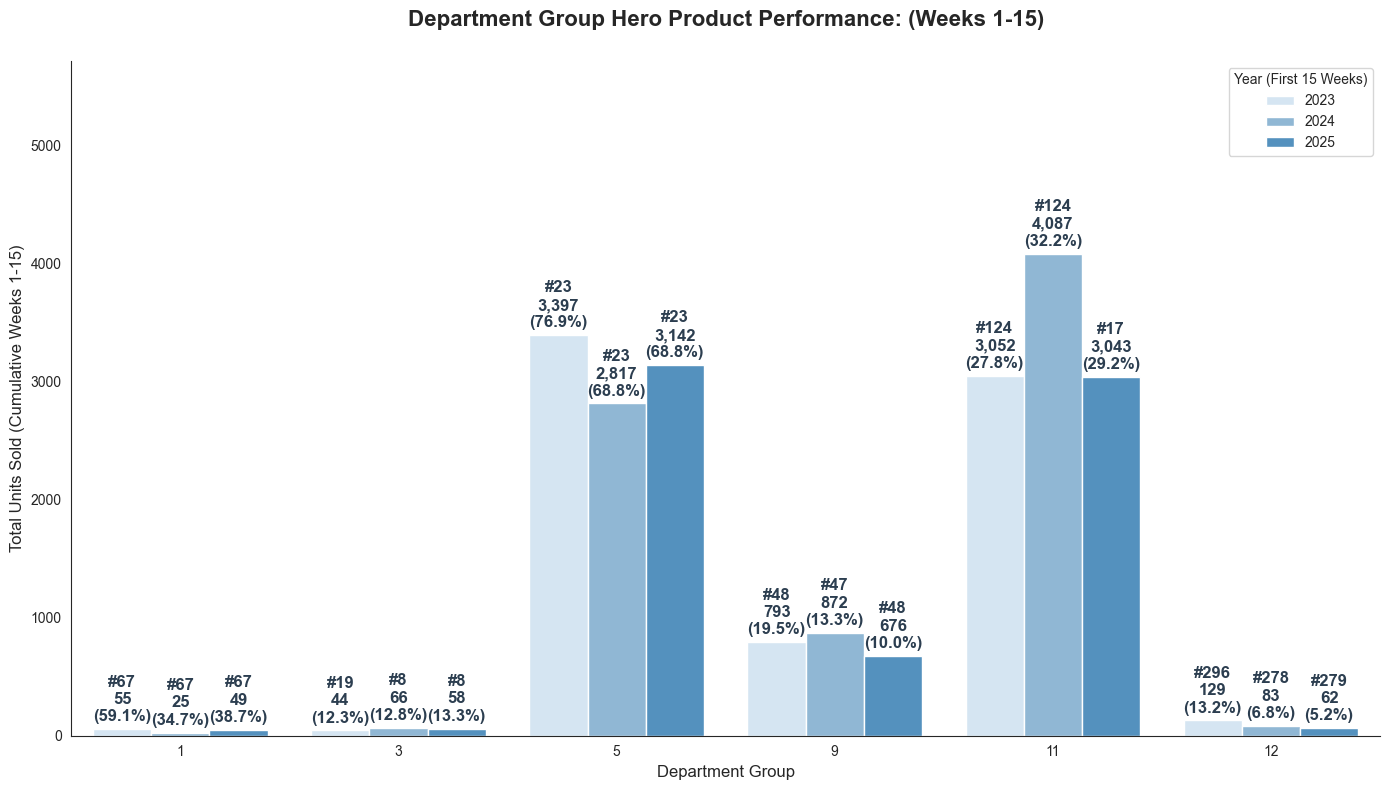

In [38]:
history = X_train_preprocessed[
    (X_train_preprocessed['year'].isin([2023, 2024])) & 
    (X_train_preprocessed['week_of_year'] <= 15)
].copy()

forecast = df_results_preprocessed.copy()
forecast['year'] = 2025
forecast = forecast[forecast['week_of_year'] <= 15]

keep_cols = ['department_group', 'year', 'product_number', 'sales']
combined_data = pd.concat([history[keep_cols], forecast[keep_cols]], ignore_index=True)

dept_totals = (
    combined_data.groupby(['department_group', 'year'])['sales']
    .sum().reset_index().rename(columns={'sales': 'total_dept_sales'})
)

sku_stats = (
    combined_data.groupby(['department_group', 'year', 'product_number'])['sales']
    .sum().reset_index()
)

top_1_dept_all = (
    sku_stats.sort_values(['department_group', 'year', 'sales'], ascending=[True, True, False])
    .groupby(['department_group', 'year']).head(1)
)

top_1_dept_all = top_1_dept_all.merge(dept_totals, on=['department_group', 'year'])
top_1_dept_all['share_pct'] = (top_1_dept_all['sales'] / top_1_dept_all['total_dept_sales']) * 100


plt.figure(figsize=(14, 8))
sns.set_style("white")
target_blue = "#4293D0" 

ax = sns.barplot(
    data=top_1_dept_all, 
    x='department_group', 
    y='sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    errorbar=None
)

num_depts = len(top_1_dept_all['department_group'].unique())
years_list = sorted(top_1_dept_all['year'].unique())
depts_list = top_1_dept_all['department_group'].unique()

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        year_idx = i // num_depts
        dept_idx = i % num_depts
        
        if year_idx < len(years_list) and dept_idx < len(depts_list):
            current_year = years_list[year_idx]
            current_dept = depts_list[dept_idx]
            
            row = top_1_dept_all[
                (top_1_dept_all['department_group'] == current_dept) & 
                (top_1_dept_all['year'] == current_year)
            ]
            
            if not row.empty:
                prod_num = row['product_number'].values[0]
                share = row['share_pct'].values[0]
                
                plt.text(
                    p.get_x() + p.get_width() / 2., 
                    height + (top_1_dept_all['sales'].max() * 0.01),
                    f'#{int(prod_num)}\n{int(height):,}\n({share:.1f}%)', 
                    ha='center', va='bottom', 
                    fontsize=12, fontweight='bold', color='#2c3e50'
                )

plt.title('Department Group Hero Product Performance: (Weeks 1-15)', 
          fontsize=16, fontweight='bold', pad=25)
plt.ylabel('Total Units Sold (Cumulative Weeks 1-15)', fontsize=12)
plt.xlabel('Department Group', fontsize=12)
plt.legend(title='Year (First 15 Weeks)', loc='upper right')

plt.ylim(0, top_1_dept_all['sales'].max() * 1.4)
sns.despine()
plt.tight_layout()
plt.savefig("images/hero_forecast_per_department.png")
plt.show()

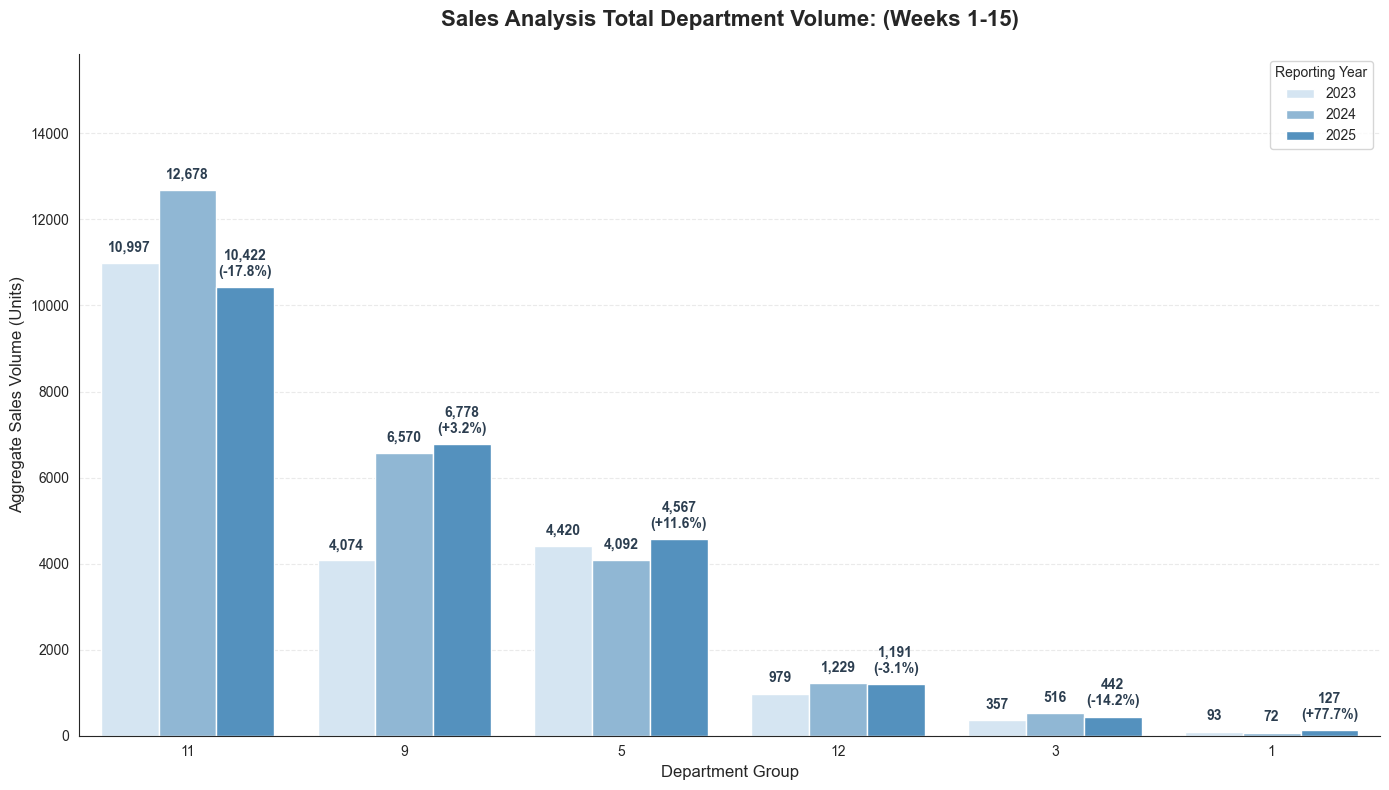

In [ ]:
keep_cols = ['department_group', 'year', 'sales']
combined_dept_data = pd.concat([history[keep_cols], forecast[keep_cols]], ignore_index=True)

dept_performance = (
    combined_dept_data.groupby(['department_group', 'year'])['sales']
    .sum()
    .reset_index()
    .rename(columns={'sales': 'total_sales'})
)

pivot_dept = dept_performance.pivot(index='department_group', columns='year', values='total_sales')
pivot_dept['growth_24_25'] = ((pivot_dept[2025] - pivot_dept[2024]) / pivot_dept[2024]) * 100

dept_performance['department_group'] = pd.Categorical(
    dept_performance['department_group'], 
    categories=pivot_dept.sort_values(2025, ascending=False).index, 
    ordered=True
)
dept_performance = dept_performance.sort_values(['department_group', 'year'])


plt.figure(figsize=(14, 8))
sns.set_style("white")

# Create grouped bar chart
ax = sns.barplot(
    data=dept_performance, 
    x='department_group', 
    y='total_sales', 
    hue='year', 
    palette=["#D0E6F7", "#84B9E0", target_blue],
    edgecolor='white'
)

num_depts = len(dept_performance['department_group'].unique())
years_list = sorted(dept_performance['year'].unique())

for i, p in enumerate(ax.patches):
    height = p.get_height()
    if height > 0:
        year_idx = i // num_depts
        dept_idx = i % num_depts
        current_year = years_list[year_idx]
        current_dept = list(pivot_dept.sort_values(2025, ascending=False).index)[dept_idx]
        
        label_text = f'{int(height):,}'
        
        if current_year == 2025:
            growth = pivot_dept.loc[current_dept, 'growth_24_25']
            label_text += f'\n({growth:+.1f}%)'
        
        plt.text(
            p.get_x() + p.get_width() / 2., 
            height + (dept_performance['total_sales'].max() * 0.015),
            label_text, 
            ha='center', va='bottom', 
            fontsize=10, fontweight='bold', 
            color='#2c3e50'
        )

# Styling
plt.title('Sales Analysis Total Department Volume: (Weeks 1-15)', 
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Aggregate Sales Volume (Units)', fontsize=12)
plt.xlabel('Department Group', fontsize=12)
plt.legend(title='Reporting Year', loc='upper right', frameon=True)

# Grid and axis cleanup
plt.ylim(0, dept_performance['total_sales'].max() * 1.25)
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()

# Save output
plt.savefig("images/department_performance_comparison.png", dpi=300)
plt.show()